In [1]:
import xarray as xr
import numpy as np
import pandas as pd

# Constants
delta_lat = 0.25       # degrees
delta_lon = 0.25       # degrees
R_EARTH = 6371000      # Earth radius in meters
DEG_TO_RAD = np.pi / 180

# -------------------------------
# 1. Load the raw hourly ERA5 datasets for 2021
# -------------------------------
print("Step 1: Loading datasets...")
u_ds = xr.open_dataset('/vol/sandeep_storage/Files2/wind_data/2021_u.nc', chunks={'time': 1})
v_ds = xr.open_dataset('/vol/sandeep_storage/Files2/wind_data/2021_v.nc', chunks={'time': 1})
phi_ds = xr.open_dataset('/vol/sandeep_storage/Files2/wind_data/2021_phi.nc', chunks={'time': 1})
print(" Datasets loaded. Dimensions:")
print(" - u:", u_ds.dims)
print(" - v:", v_ds.dims)
print(" - phi:", phi_ds.dims)

# -------------------------------
# 2. Compute Daily Mean Fields
# -------------------------------
print("Step 2: Computing daily means...")
u_daily = u_ds['u'].resample(valid_time='1D').mean()
v_daily = v_ds['v'].resample(valid_time='1D').mean()
phi_daily = phi_ds['z'].resample(valid_time='1D').mean()
print(" Daily means computed. Shapes:")
print(" - u_daily:", u_daily.shape)
print(" - v_daily:", v_daily.shape)
print(" - phi_daily:", phi_daily.shape)

# -------------------------------
# 3. Compute Spatial Derivatives (Central Differences)
# -------------------------------
# a) Derivative in the north-south (y) direction
dy = delta_lat * DEG_TO_RAD * R_EARTH
phi_prev_y = phi_daily.roll(latitude=-1, roll_coords=False)
phi_next_y = phi_daily.roll(latitude=1, roll_coords=False)
dphi_dy = (phi_next_y - phi_prev_y) / (2 * dy)
print(" dphi/dy computed.")

# b) Derivative in the east-west (x) direction
dx = delta_lon * DEG_TO_RAD * R_EARTH * np.cos(phi_daily['latitude'] * DEG_TO_RAD)
phi_prev_x = phi_daily.roll(longitude=-1, roll_coords=False)
phi_next_x = phi_daily.roll(longitude=1, roll_coords=False)
dphi_dx = (phi_next_x - phi_prev_x) / (2 * dx)
print(" dphi/dx computed.")

# -------------------------------
# 4. Compute KE Generation
# -------------------------------
ke_gen = - u_daily * dphi_dx - v_daily * dphi_dy
print(" KE generation computed. Shape:", ke_gen.shape)

# -------------------------------
# 5. Convert to DataFrame
# -------------------------------
# Create dataset for KE gen
ke_gen_ds = ke_gen.to_dataset(name='ke_gen')

# Optionally include a dummy 'number' variable for structure
ke_gen_ds['number'] = xr.zeros_like(ke_gen.isel(valid_time=0))  # shape match
ke_gen_ds['number'] = ke_gen_ds['number'].expand_dims({'valid_time': ke_gen['valid_time']})
ke_gen_ds['number'] = ke_gen_ds['number'].assign_coords(valid_time=ke_gen['valid_time'])

# Convert to DataFrame
df_ke_gen = ke_gen_ds[['ke_gen', 'number']].to_dataframe().reset_index()
df_ke_gen = df_ke_gen[['valid_time', 'latitude', 'longitude', 'pressure_level', 'number', 'ke_gen']]
print(" Converted to DataFrame. Shape:", df_ke_gen.shape)

# -------------------------------
# 6. Save to Parquet
# -------------------------------
output_path = '/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_gen_daily.parquet'
df_ke_gen.to_parquet(output_path, index=False)
print(f" Saved KE generation data to:\n{output_path}")


Step 1: Loading datasets...
✅ Datasets loaded. Dimensions:
 - u: Frozen({'valid_time': 8760, 'pressure_level': 1, 'latitude': 721, 'longitude': 1440})
 - v: Frozen({'valid_time': 8760, 'pressure_level': 1, 'latitude': 721, 'longitude': 1440})
 - phi: Frozen({'valid_time': 8760, 'pressure_level': 1, 'latitude': 721, 'longitude': 1440})
Step 2: Computing daily means...
✅ Daily means computed. Shapes:
 - u_daily: (365, 1, 721, 1440)
 - v_daily: (365, 1, 721, 1440)
 - phi_daily: (365, 1, 721, 1440)
✅ dphi/dy computed.
✅ dphi/dx computed.
✅ KE generation computed. Shape: (365, 1, 721, 1440)
✅ Converted to DataFrame. Shape: (378957600, 6)
✅ Saved KE generation data to:
/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_gen_daily.parquet


In [2]:
xx=pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_gen_daily.parquet')
xx


valid_time  latitude  longitude  pressure_level  number    ke_gen
0         2021-01-01      90.0       0.00          1000.0     0.0  0.000002
1         2021-01-01      90.0       0.25          1000.0     0.0  0.000002
2         2021-01-01      90.0       0.50          1000.0     0.0  0.000002
3         2021-01-01      90.0       0.75          1000.0     0.0  0.000002
4         2021-01-01      90.0       1.00          1000.0     0.0  0.000002
...              ...       ...        ...             ...     ...       ...
378957595 2021-12-31     -90.0     358.75          1000.0     0.0  0.000005
378957596 2021-12-31     -90.0     359.00          1000.0     0.0  0.000005
378957597 2021-12-31     -90.0     359.25          1000.0     0.0  0.000005
378957598 2021-12-31     -90.0     359.50          1000.0     0.0  0.000005
378957599 2021-12-31     -90.0     359.75          1000.0     0.0  0.000005

[378957600 rows x 6 columns]

In [5]:
import xarray as xr
import numpy as np
import pandas as pd

# Constants
delta_lat = 0.25       # degrees
delta_lon = 0.25       # degrees
R_EARTH = 6371000      # Earth radius in meters
DEG_TO_RAD = np.pi / 180

# -------------------------------
# 1. Load the hourly ERA5 u and v datasets for 2021
# -------------------------------
print("Step 1: Loading datasets...")
u_ds = xr.open_dataset('/vol/sandeep_storage/Files2/wind_data/2021_u.nc', chunks={'time': 1})
v_ds = xr.open_dataset('/vol/sandeep_storage/Files2/wind_data/2021_v.nc', chunks={'time': 1})
print(" Datasets loaded. Dimensions:")
print(" - u:", u_ds.dims)
print(" - v:", v_ds.dims)

# -------------------------------
# 2. Compute Daily Mean Fields
# -------------------------------
print("Step 2: Computing daily means...")
u_daily = u_ds['u'].resample(valid_time='1D').mean()
v_daily = v_ds['v'].resample(valid_time='1D').mean()
print(" Daily means computed. Shapes:")
print(" - u_daily:", u_daily.shape)
print(" - v_daily:", v_daily.shape)

# -------------------------------
# 3. Compute KE (0.5 * (u^2 + v^2))
# -------------------------------
ke = 0.5 * (u_daily**2 + v_daily**2)
print(" Kinetic energy computed.")

# -------------------------------
# 4. Compute Spatial Derivatives of KE
# -------------------------------
# a) dKE/dy (north-south)
dy = delta_lat * DEG_TO_RAD * R_EARTH
ke_prev_y = ke.roll(latitude=-1, roll_coords=False)
ke_next_y = ke.roll(latitude=1, roll_coords=False)
dke_dy = (ke_next_y - ke_prev_y) / (2 * dy)
print(" dKE/dy computed.")

# b) dKE/dx (east-west)
dx = delta_lon * DEG_TO_RAD * R_EARTH * np.cos(ke['latitude'] * DEG_TO_RAD)
ke_prev_x = ke.roll(longitude=-1, roll_coords=False)
ke_next_x = ke.roll(longitude=1, roll_coords=False)
dke_dx = (ke_next_x - ke_prev_x) / (2 * dx)
print(" dKE/dx computed.")

# -------------------------------
# 5. Compute KE Advection: u·dKE/dx + v·dKE/dy
# -------------------------------
ke_advection = u_daily * dke_dx + v_daily * dke_dy
print(" KE advection computed.")

# -------------------------------
# 6. Convert to DataFrame
# -------------------------------
ds_daily = ke_advection.to_dataset(name='ke_advection')

# Convert to DataFrame
df_ke_adv = ds_daily['ke_advection'].to_dataframe().reset_index()
df_ke_adv = df_ke_adv[['valid_time', 'latitude', 'longitude', 'pressure_level', 'ke_advection']]
print(" DataFrame created. Shape:", df_ke_adv.shape)

# -------------------------------
# 7. Save to Parquet
# -------------------------------
output_path = '/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_adv_daily.parquet'
df_ke_adv.to_parquet(output_path, index=False)
print(f" Saved KE advection data to:\n{output_path}")


Step 1: Loading datasets...
✅ Datasets loaded. Dimensions:
 - u: Frozen({'valid_time': 8760, 'pressure_level': 1, 'latitude': 721, 'longitude': 1440})
 - v: Frozen({'valid_time': 8760, 'pressure_level': 1, 'latitude': 721, 'longitude': 1440})
Step 2: Computing daily means...
✅ Daily means computed. Shapes:
 - u_daily: (365, 1, 721, 1440)
 - v_daily: (365, 1, 721, 1440)
✅ Kinetic energy computed.
✅ dKE/dy computed.
✅ dKE/dx computed.
✅ KE advection computed.
✅ DataFrame created. Shape: (378957600, 5)
✅ Saved KE advection data to:
/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_adv_daily.parquet


### KE ADV DATA

In [6]:
vv=pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_adv_daily.parquet')
vv


valid_time  latitude  longitude  pressure_level  ke_advection
0         2021-01-01      90.0       0.00          1000.0 -1.031728e-07
1         2021-01-01      90.0       0.25          1000.0 -1.031823e-07
2         2021-01-01      90.0       0.50          1000.0 -1.031954e-07
3         2021-01-01      90.0       0.75          1000.0 -1.032078e-07
4         2021-01-01      90.0       1.00          1000.0 -1.032176e-07
...              ...       ...        ...             ...           ...
378957595 2021-12-31     -90.0     358.75          1000.0  4.452871e-08
378957596 2021-12-31     -90.0     359.00          1000.0  4.459896e-08
378957597 2021-12-31     -90.0     359.25          1000.0  4.466620e-08
378957598 2021-12-31     -90.0     359.50          1000.0  4.473644e-08
378957599 2021-12-31     -90.0     359.75          1000.0  4.480344e-08

[378957600 rows x 5 columns]

### PCA FOR EUROPE

In [2]:
import pandas as pd
xx=pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_gen_daily.parquet')
xx


valid_time  latitude  longitude  pressure_level  number    ke_gen
0         2021-01-01      90.0       0.00          1000.0     0.0  0.000002
1         2021-01-01      90.0       0.25          1000.0     0.0  0.000002
2         2021-01-01      90.0       0.50          1000.0     0.0  0.000002
3         2021-01-01      90.0       0.75          1000.0     0.0  0.000002
4         2021-01-01      90.0       1.00          1000.0     0.0  0.000002
...              ...       ...        ...             ...     ...       ...
378957595 2021-12-31     -90.0     358.75          1000.0     0.0  0.000005
378957596 2021-12-31     -90.0     359.00          1000.0     0.0  0.000005
378957597 2021-12-31     -90.0     359.25          1000.0     0.0  0.000005
378957598 2021-12-31     -90.0     359.50          1000.0     0.0  0.000005
378957599 2021-12-31     -90.0     359.75          1000.0     0.0  0.000005

[378957600 rows x 6 columns]

In [68]:
import pandas as pd

# Read the parquet file
ke_gen_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_gen_daily.parquet')

# Ensure valid_time is a datetime type
ke_gen_df['valid_time'] = pd.to_datetime(ke_gen_df['valid_time'])

# Convert longitudes from 0–360 to -180–180
#ke_gen_df['longitude'] = ke_gen_df['longitude'] % 360
#ke_gen_df.loc[ke_gen_df['longitude'] > 180, 'longitude'] -= 360

# Filter for region: lat [20, 75], lon [110, 220]
monsoon_df = ke_gen_df[
    (ke_gen_df['latitude'] >= 20) &
    (ke_gen_df['latitude'] <=75) &
    (ke_gen_df['longitude'] >= 110) &
    (ke_gen_df['longitude'] <= 220)
]

# Display the filtered DataFrame
print(monsoon_df.head())


      valid_time  latitude  longitude  pressure_level  number    ke_gen
86840 2021-01-01      75.0     110.00          1000.0     0.0  0.000425
86841 2021-01-01      75.0     110.25          1000.0     0.0  0.000181
86842 2021-01-01      75.0     110.50          1000.0     0.0  0.000049
86843 2021-01-01      75.0     110.75          1000.0     0.0  0.000001
86844 2021-01-01      75.0     111.00          1000.0     0.0 -0.000023


In [87]:
import pandas as pd

# Read the parquet file
ke_gen_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_adv_daily.parquet')

# Ensure valid_time is a datetime type
ke_gen_df['valid_time'] = pd.to_datetime(ke_gen_df['valid_time'])

# Filter for region: lat [-50, 0], lon [145, 205]
monsoon_df = ke_gen_df[
    (ke_gen_df['latitude'] >= 20) &
    (ke_gen_df['latitude'] <= 75) &
    (ke_gen_df['longitude'] >= 110) &
    (ke_gen_df['longitude'] <= 220)
].copy()  # copy to avoid SettingWithCopyWarning

#  Convert all ke_advection values to their negative
monsoon_df['ke_advection'] = -monsoon_df['ke_advection']

# Display the modified DataFrame
print(monsoon_df.head())


      valid_time  latitude  longitude  pressure_level  ke_advection
86840 2021-01-01      75.0     110.00          1000.0      0.000289
86841 2021-01-01      75.0     110.25          1000.0      0.000324
86842 2021-01-01      75.0     110.50          1000.0      0.000229
86843 2021-01-01      75.0     110.75          1000.0      0.000120
86844 2021-01-01      75.0     111.00          1000.0      0.000063


In [88]:
# 3. Create a pivot table with a MultiIndex for columns (latitude and longitude)
pivot_df = monsoon_df.pivot_table(index='valid_time', columns=['latitude', 'longitude'], values='ke_advection')
print("\nPivot Table (first 5 rows):")
print(pivot_df.head())



Pivot Table (first 5 rows):
latitude        20.0                                                    \
longitude     110.00    110.25    110.50    110.75    111.00    111.25   
valid_time                                                               
2021-01-01 -0.000640 -0.000371  0.000275 -0.000210 -0.001368 -0.001600   
2021-01-02  0.000022  0.000416  0.000749  0.000261 -0.000535 -0.000676   
2021-01-03 -0.000810 -0.000711  0.000284 -0.000422 -0.002621 -0.003146   
2021-01-04  0.000044  0.000233  0.000614 -0.000067 -0.001478 -0.001953   
2021-01-05 -0.000053  0.000099  0.000489 -0.000111 -0.001427 -0.001531   

latitude                                            ...      75.0            \
longitude     111.50    111.75    112.00    112.25  ...    217.75    218.00   
valid_time                                          ...                       
2021-01-01 -0.001370 -0.001433 -0.001439 -0.001576  ...  0.000159  0.000173   
2021-01-02 -0.000471 -0.000500 -0.000619 -0.000910  ...  0.000

In [31]:
#4. Check if any NaN exists in the DataFrame
if pivot_df.isna().any().any():
    print("There are missing values in the pivot table.")
else:
    print("No missing values found in the pivot table.")


No missing values found in the pivot table.


In [90]:
# 5. Prepare the data matrix for PCA: each row is a time snapshot, each column a spatial grid point
X = pivot_df.values
print("\nData matrix shape for PCA:", X.shape)



Data matrix shape for PCA: (365, 97461)


In [91]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [92]:
# 6. Standardize the data so each grid point has zero mean and unit variance
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)
print("\nStandardized data (first 5 rows):")
print(X_standardized[:5, :])



Standardized data (first 5 rows):
[[-0.77516183 -0.62442003  0.15655588 ...  0.11369434  0.12099963
   0.12698326]
 [ 0.27152838  0.86421809  0.48696668 ...  0.29153807  0.3053599
   0.29415354]
 [-1.04443632 -1.26749684  0.16263143 ... -0.22064084 -0.25122505
  -0.27586723]
 [ 0.3069196   0.5180988   0.39278198 ... -0.09853634 -0.10415029
  -0.12077025]
 [ 0.15286829  0.26417748  0.3060826  ... -0.28652425 -0.30868894
  -0.33300547]]


In [93]:
# 7. Apply PCA to extract the first 10 principal components from the standardized data
pca = PCA(n_components=10)
PC_scores = pca.fit_transform(X_standardized)
print("\nShape of PCA scores:", PC_scores.shape)
print("\nFirst 5 rows of PCA scores:")
print(PC_scores[:5, :])



Shape of PCA scores: (365, 10)

First 5 rows of PCA scores:
[[ 90.42826419  72.39522975 -22.23229796 -15.15121834  24.48432697
  110.98506271  53.40356668  57.06771398  22.62396407  97.51939201]
 [ 79.85949688  47.29904613  -5.94766762   0.30966713  14.53931111
   55.85505161  23.09643001  34.4469999  -16.22469903  42.13447255]
 [ 73.53355084  42.32980429 -12.26910681  -5.06712076  10.82602378
   26.87867354   8.77710836  27.21566209  -4.57791068  31.48029485]
 [ 41.49596016  34.51034958  13.77032199  -1.16967241  -8.08312069
   14.90835391  37.78780136  15.30315217  -4.52475196  39.7624758 ]
 [ 28.75118998  59.66297427  58.58980227   4.19454856   9.13378843
    7.33860735  24.43649818  -6.43192152  16.29515428  24.40033639]]


In [94]:
print("Explained Variance (PC1 to PC10):", pca.explained_variance_)


Explained Variance (PC1 to PC10): [3401.005267   2437.15064265 1756.28316805 1734.76302751 1503.28036244
 1382.49216827 1322.14472347 1277.94585107 1188.95462476 1172.21492751]


In [95]:
print("Explained Variance Ratio(PC1 to PC10):",pca.explained_variance_ratio_)


Explained Variance Ratio(PC1 to PC10): [0.03480046 0.02493791 0.017971   0.0177508  0.01538217 0.01414622
 0.01352872 0.01307646 0.01216586 0.01199458]


In [96]:
import numpy as np
pca_full = PCA(n_components=None)
pca_full.fit(X_standardized)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
print("Number of components to capture 90% variance:", n_components_90)


Number of components to capture 90% variance: 228


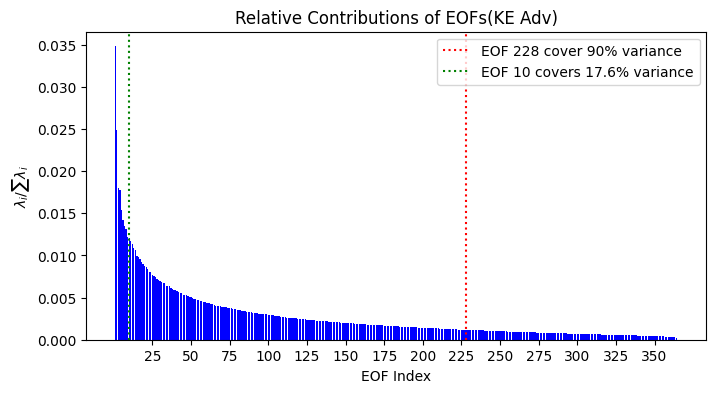

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already computed:
lambda_vals = pca_full.explained_variance_
relative_contributions = lambda_vals / np.sum(lambda_vals)

# Calculate the cumulative sum of the relative contributions
cumulative_contributions = np.cumsum(relative_contributions)

# Find the minimum number of EOFs required to cover at least 90% of the total variance
n_eof = np.argmax(cumulative_contributions >= 0.9) + 1  # add 1 since indices start at 0

plt.figure(figsize=(8, 4))
indices = np.arange(1, len(lambda_vals) + 1)
plt.bar(indices, relative_contributions, color='blue')
plt.xlabel('EOF Index')
plt.ylabel(r'$\lambda_i/\sum \lambda_i$')
plt.title('Relative Contributions of EOFs(KE Adv)')

# Draw a dotted vertical red line at the required EOF index for 90% variance
plt.axvline(x=n_eof, color='red', linestyle=':', 
            label=f'EOF {n_eof} cover 90% variance')

# If there are at least 10 EOFs, annotate the cumulative variance covered by EOF 10
if len(lambda_vals) >= 10:
    var_eof10 = cumulative_contributions[9]  # 10th EOF (index 9)
    plt.axvline(x=10, color='green', linestyle=':', 
                label=f'EOF 10 covers {var_eof10*100:.1f}% variance')

# Hide x-axis ticks
#plt.xticks([])
# Set x-axis ticks at intervals of 25
tick_positions = np.arange(25, len(lambda_vals)+1,25)
plt.xticks(tick_positions, tick_positions)
plt.legend()
plt.show()


In [98]:
from sklearn.decomposition import PCA
import numpy as np

# Fit full PCA (all components)
pca_full = PCA(n_components=None)
pca_full.fit(X_standardized)

# Compute the sum of explained variance ratios
explained_ratio_sum = np.sum(pca_full.explained_variance_ratio_)
print("Sum of explained variance ratios:", explained_ratio_sum)

# Check if the sum is approximately equal to 1
if np.isclose(explained_ratio_sum, 1.0):
    print("The sum of explained variance ratios is 1.")
else:
    print("The sum of explained variance ratios is NOT 1.")



Sum of explained variance ratios: 1.0000000000000002
The sum of explained variance ratios is 1.


In [99]:
# 8. Create a DataFrame for the PC time series using valid_time as the index
PC_df = pd.DataFrame(PC_scores, index=pivot_df.index, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5','PC6','PC7','PC8','PC9','PC10'])
print("\nPrincipal Component Time Series DataFrame (first 5 rows):")
print(PC_df.head())
PC_df.to_parquet('/vol/sandeep_storage/Files2/wind_data/europe/keadvvvv_europe_PC_time_series_2021.parquet')



Principal Component Time Series DataFrame (first 5 rows):
                  PC1        PC2        PC3        PC4        PC5         PC6  \
valid_time                                                                      
2021-01-01  90.428264  72.395230 -22.232298 -15.151218  24.484327  110.985063   
2021-01-02  79.859497  47.299046  -5.947668   0.309667  14.539311   55.855052   
2021-01-03  73.533551  42.329804 -12.269107  -5.067121  10.826024   26.878674   
2021-01-04  41.495960  34.510350  13.770322  -1.169672  -8.083121   14.908354   
2021-01-05  28.751190  59.662974  58.589802   4.194549   9.133788    7.338607   

                  PC7        PC8        PC9       PC10  
valid_time                                              
2021-01-01  53.403567  57.067714  22.623964  97.519392  
2021-01-02  23.096430  34.447000 -16.224699  42.134473  
2021-01-03   8.777108  27.215662  -4.577911  31.480295  
2021-01-04  37.787801  15.303152  -4.524752  39.762476  
2021-01-05  24.436498  -6.43192

In [23]:
# 8. Create a DataFrame for the PC time series using valid_time as the index
PC_columns = [f'PC{i}' for i in range(1, 31)]  # PC1 to PC30
PC_df = pd.DataFrame(PC_scores[:, :30], index=pivot_df.index, columns=PC_columns)

print("\nPrincipal Component Time Series DataFrame (first 5 rows):")
print(PC_df.head())

# Save to Parquet file
PC_df.to_parquet('/vol/sandeep_storage/Files2/wind_data/europe/keadv_europe_PC_time_series_2021_30.parquet')



Principal Component Time Series DataFrame (first 5 rows):
                  PC1        PC2        PC3        PC4        PC5         PC6  \
valid_time                                                                      
2021-01-01  90.429283  72.399261 -22.318334 -15.405196  23.996644  111.117789   
2021-01-02  79.859467  47.298550  -5.968839   0.323318  14.474563   55.595449   
2021-01-03  73.533644  42.331377 -12.261436  -5.128917  10.850917   26.927895   
2021-01-04  41.496060  34.510509  13.745480  -1.162475  -8.174049   14.926813   
2021-01-05  28.751142  59.661898  58.571035   4.218690   9.185765    7.528918   

                  PC7        PC8        PC9       PC10  ...       PC21  \
valid_time                                              ...              
2021-01-01  54.243878 -57.509063  22.462752  90.874576  ... -32.204189   
2021-01-02  23.292200 -35.025083 -17.321405  38.132153  ...  25.884227   
2021-01-03   9.040663 -27.290968  -5.185905  29.268459  ...  12.113615   
202

In [100]:
# 9. Reconstruct the EOFs (PCA loadings) back to a geographic grid.
EOFs = pca.components_
print("\nShape of PCA components (EOFs):", EOFs.shape)

# 10. Subtract 180 from each longitude (as per your instruction)
monsoon_df = monsoon_df.copy()
monsoon_df['longitude'] = monsoon_df['longitude'] - 180

# Now get unique latitude and longitude values (sorted)
lat_vals = np.sort(monsoon_df['latitude'].unique())
lon_vals = np.sort(monsoon_df['longitude'].unique())
print("\nUnique latitudes:", lat_vals)
print("Unique longitudes (after subtracting 180):", lon_vals)

n_lat = len(lat_vals)
n_lon = len(lon_vals)

# 11. Reshape each EOF back into (n_lat, n_lon) grid
EOF_maps = {}
for i in range(10):
    eof_map = EOFs[i, :].reshape(n_lat, n_lon)
    EOF_maps[f'EOF{i+1}'] = eof_map
    print(f"\nEOF{i+1} map shape: {eof_map.shape}")



Shape of PCA components (EOFs): (10, 97461)

Unique latitudes: [20.   20.25 20.5  20.75 21.   21.25 21.5  21.75 22.   22.25 22.5  22.75
 23.   23.25 23.5  23.75 24.   24.25 24.5  24.75 25.   25.25 25.5  25.75
 26.   26.25 26.5  26.75 27.   27.25 27.5  27.75 28.   28.25 28.5  28.75
 29.   29.25 29.5  29.75 30.   30.25 30.5  30.75 31.   31.25 31.5  31.75
 32.   32.25 32.5  32.75 33.   33.25 33.5  33.75 34.   34.25 34.5  34.75
 35.   35.25 35.5  35.75 36.   36.25 36.5  36.75 37.   37.25 37.5  37.75
 38.   38.25 38.5  38.75 39.   39.25 39.5  39.75 40.   40.25 40.5  40.75
 41.   41.25 41.5  41.75 42.   42.25 42.5  42.75 43.   43.25 43.5  43.75
 44.   44.25 44.5  44.75 45.   45.25 45.5  45.75 46.   46.25 46.5  46.75
 47.   47.25 47.5  47.75 48.   48.25 48.5  48.75 49.   49.25 49.5  49.75
 50.   50.25 50.5  50.75 51.   51.25 51.5  51.75 52.   52.25 52.5  52.75
 53.   53.25 53.5  53.75 54.   54.25 54.5  54.75 55.   55.25 55.5  55.75
 56.   56.25 56.5  56.75 57.   57.25 57.5  57.75 58.   58.25

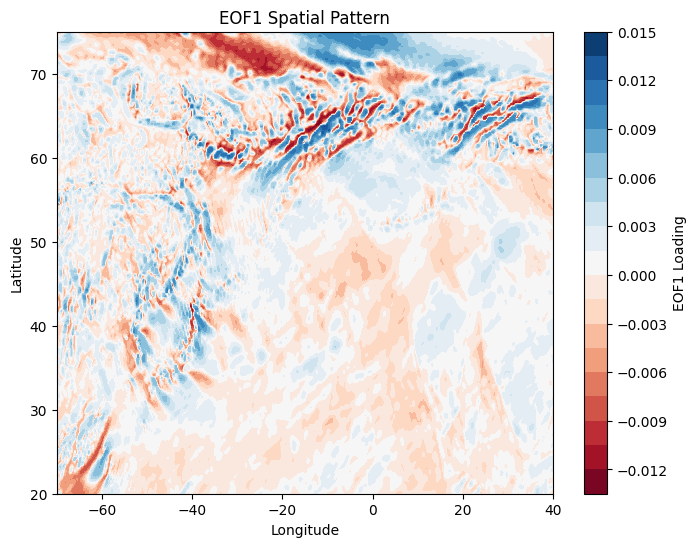

In [101]:
import matplotlib.pyplot as plt
import numpy as np

# Assume EOF_maps dictionary holds our EOF maps with keys 'EOF1', 'EOF2', etc.
# Also assume lat_vals and lon_vals are our sorted latitude and longitude arrays.

EOF1 = EOF_maps['EOF1']

plt.figure(figsize=(8, 6))
# Create a meshgrid for plotting
lon_mesh, lat_mesh = np.meshgrid(lon_vals, lat_vals)

# Plot the EOF map using contourf (filled contours)
plt.contourf(lon_mesh, lat_mesh, EOF1, cmap='RdBu', levels=20)
plt.colorbar(label='EOF1 Loading')
plt.title('EOF1 Spatial Pattern')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


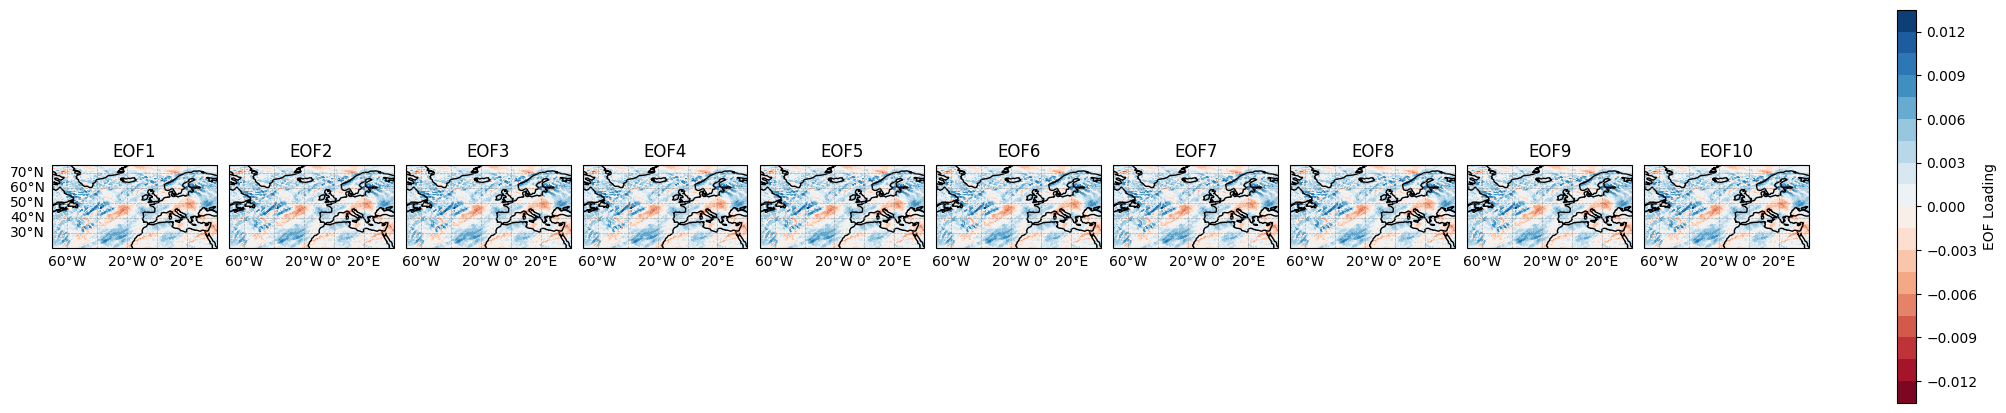

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# Create a meshgrid for plotting using your sorted lon and lat arrays
lon_mesh, lat_mesh = np.meshgrid(lon_vals, lat_vals)

# Create a figure with 10 subplots arranged horizontally using PlateCarree projection
fig, axs = plt.subplots(1, 10, figsize=(20, 5),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

# Loop over each EOF and plot with coastlines and gridlines
for i, key in enumerate(['EOF1', 'EOF2', 'EOF3', 'EOF4', 'EOF5', 'EOF6', 'EOF7', 'EOF8', 'EOF9', 'EOF10']):
    # Invert the sign for 'EOF2'
    #if key in ['EOF1','EOF2','EOF3','EOF8']:
      # eof_map = -EOF_maps[key]
    #else:
      # eof_map = EOF_maps[key]
    
    # Create filled contour plot
    cs = axs[i].contourf(lon_mesh, lat_mesh, eof_map, levels=20, cmap='RdBu',
                         transform=ccrs.PlateCarree())
    
    # Add coastlines
    axs[i].coastlines()
    
    # Set extent to cover the full range of lon and lat values
    axs[i].set_extent([lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()], 
                      crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = axs[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i == 0:
        axs[i].set_ylabel('Latitude')
    else:
        gl.left_labels = False  # Only show left labels for the first subplot
    
    axs[i].set_title(key)

# Add a single colorbar for all subplots
fig.colorbar(cs, ax=axs.ravel().tolist(), shrink=0.8, label='EOF Loading')

plt.show()


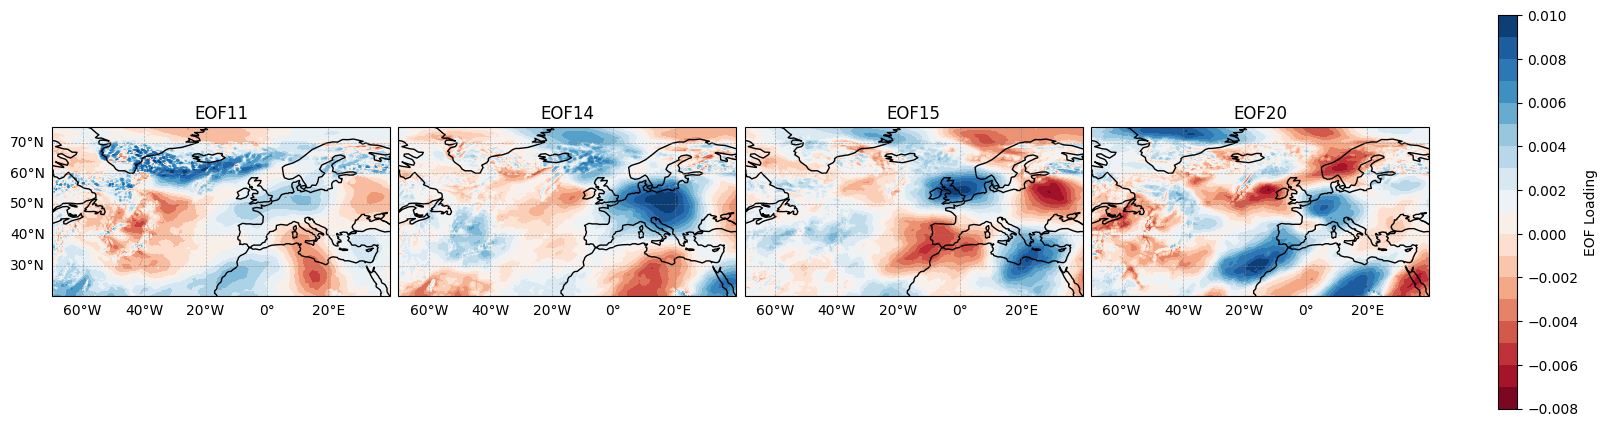

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# Create a meshgrid for plotting using your sorted lon and lat arrays
lon_mesh, lat_mesh = np.meshgrid(lon_vals, lat_vals)

# Define the specific EOFs to plot
selected_eofs = ['EOF1', 'EOF4', 'EOF5', 'EOF10']

# Create a figure with 4 subplots (one for each selected EOF)
fig, axs = plt.subplots(1, len(selected_eofs), figsize=(16, 5),
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        constrained_layout=True)

# Plot each selected EOF
for i, key in enumerate(selected_eofs):
    eof_map = EOF_maps[key]

    # Create filled contour plot
    cs = axs[i].contourf(lon_mesh, lat_mesh, eof_map, levels=20, cmap='RdBu',
                         transform=ccrs.PlateCarree())

    axs[i].coastlines()
    axs[i].set_extent([lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
                      crs=ccrs.PlateCarree())

    # Gridlines
    gl = axs[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i == 0:
        axs[i].set_ylabel('Latitude')
    else:
        gl.left_labels = False

    # Add +10 to the EOF number in title
    eof_number = int(key.replace('EOF', '')) + 10
    axs[i].set_title(f'EOF{eof_number}')

# Add shared colorbar
fig.colorbar(cs, ax=axs.ravel().tolist(), shrink=0.8, label='EOF Loading')

plt.show()


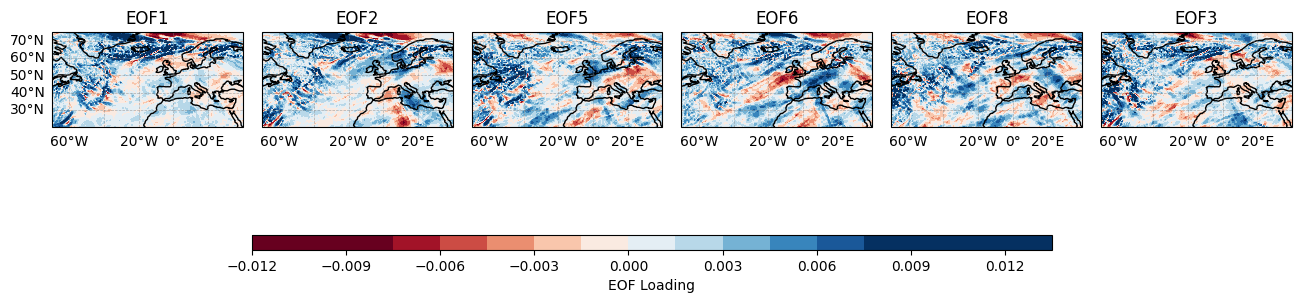

In [104]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs

# Create a meshgrid for plotting using your sorted lon and lat arrays
lon_mesh, lat_mesh = np.meshgrid(lon_vals, lat_vals)

# Define the specific EOFs to plot
selected_eofs = ['EOF1', 'EOF2', 'EOF5','EOF6', 'EOF8','EOF3']

# Create a figure with 4 subplots (one for each selected EOF)
fig, axs = plt.subplots(1, len(selected_eofs), figsize=(16, 5),
                        subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(bottom=0.2, wspace=0.1)  # Space for horizontal colorbar

# Plot each selected EOF
for i, key in enumerate(selected_eofs):
    
    eof_map = -EOF_maps[key] if key in ['EOF1', 'EOF6'] else EOF_maps[key]
    # Create filled contour plot with fixed range
    cs = axs[i].contourf(lon_mesh, lat_mesh, eof_map, levels=20, cmap='RdBu',
                         vmin=-0.008, vmax=0.008,
                         transform=ccrs.PlateCarree())

    axs[i].coastlines()
    axs[i].set_extent([lon_vals.min(), lon_vals.max(), lat_vals.min(), lat_vals.max()],
                      crs=ccrs.PlateCarree())

    # Gridlines
    gl = axs[i].gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.6, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    if i == 0:
        axs[i].set_ylabel('Latitude')
    else:
        gl.left_labels = False

    # Add +10 to the EOF number in title
    eof_number = int(key.replace('EOF', '')) + 0
    axs[i].set_title(f'EOF{eof_number}')

# Add horizontal colorbar below all plots
cbar_ax = fig.add_axes([0.25, 0.2, 0.5, 0.03])  # [left, bottom, width, height]
fig.colorbar(cs, cax=cbar_ax, orientation='horizontal', label='EOF Loading')

plt.show()


In [18]:
bb=pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/europe_daily_2021_weighted_avg_gen.parquet')
bb


valid_time  Weighted Avg Gen (MW per MW installed)
0   2021-01-01                                1.766343
1   2021-01-02                                1.522160
2   2021-01-03                                1.374646
3   2021-01-04                                1.195836
4   2021-01-05                                1.164599
..         ...                                     ...
360 2021-12-27                                1.565851
361 2021-12-28                                1.666260
362 2021-12-29                                1.426110
363 2021-12-30                                1.559082
364 2021-12-31                                1.571332

[365 rows x 2 columns]

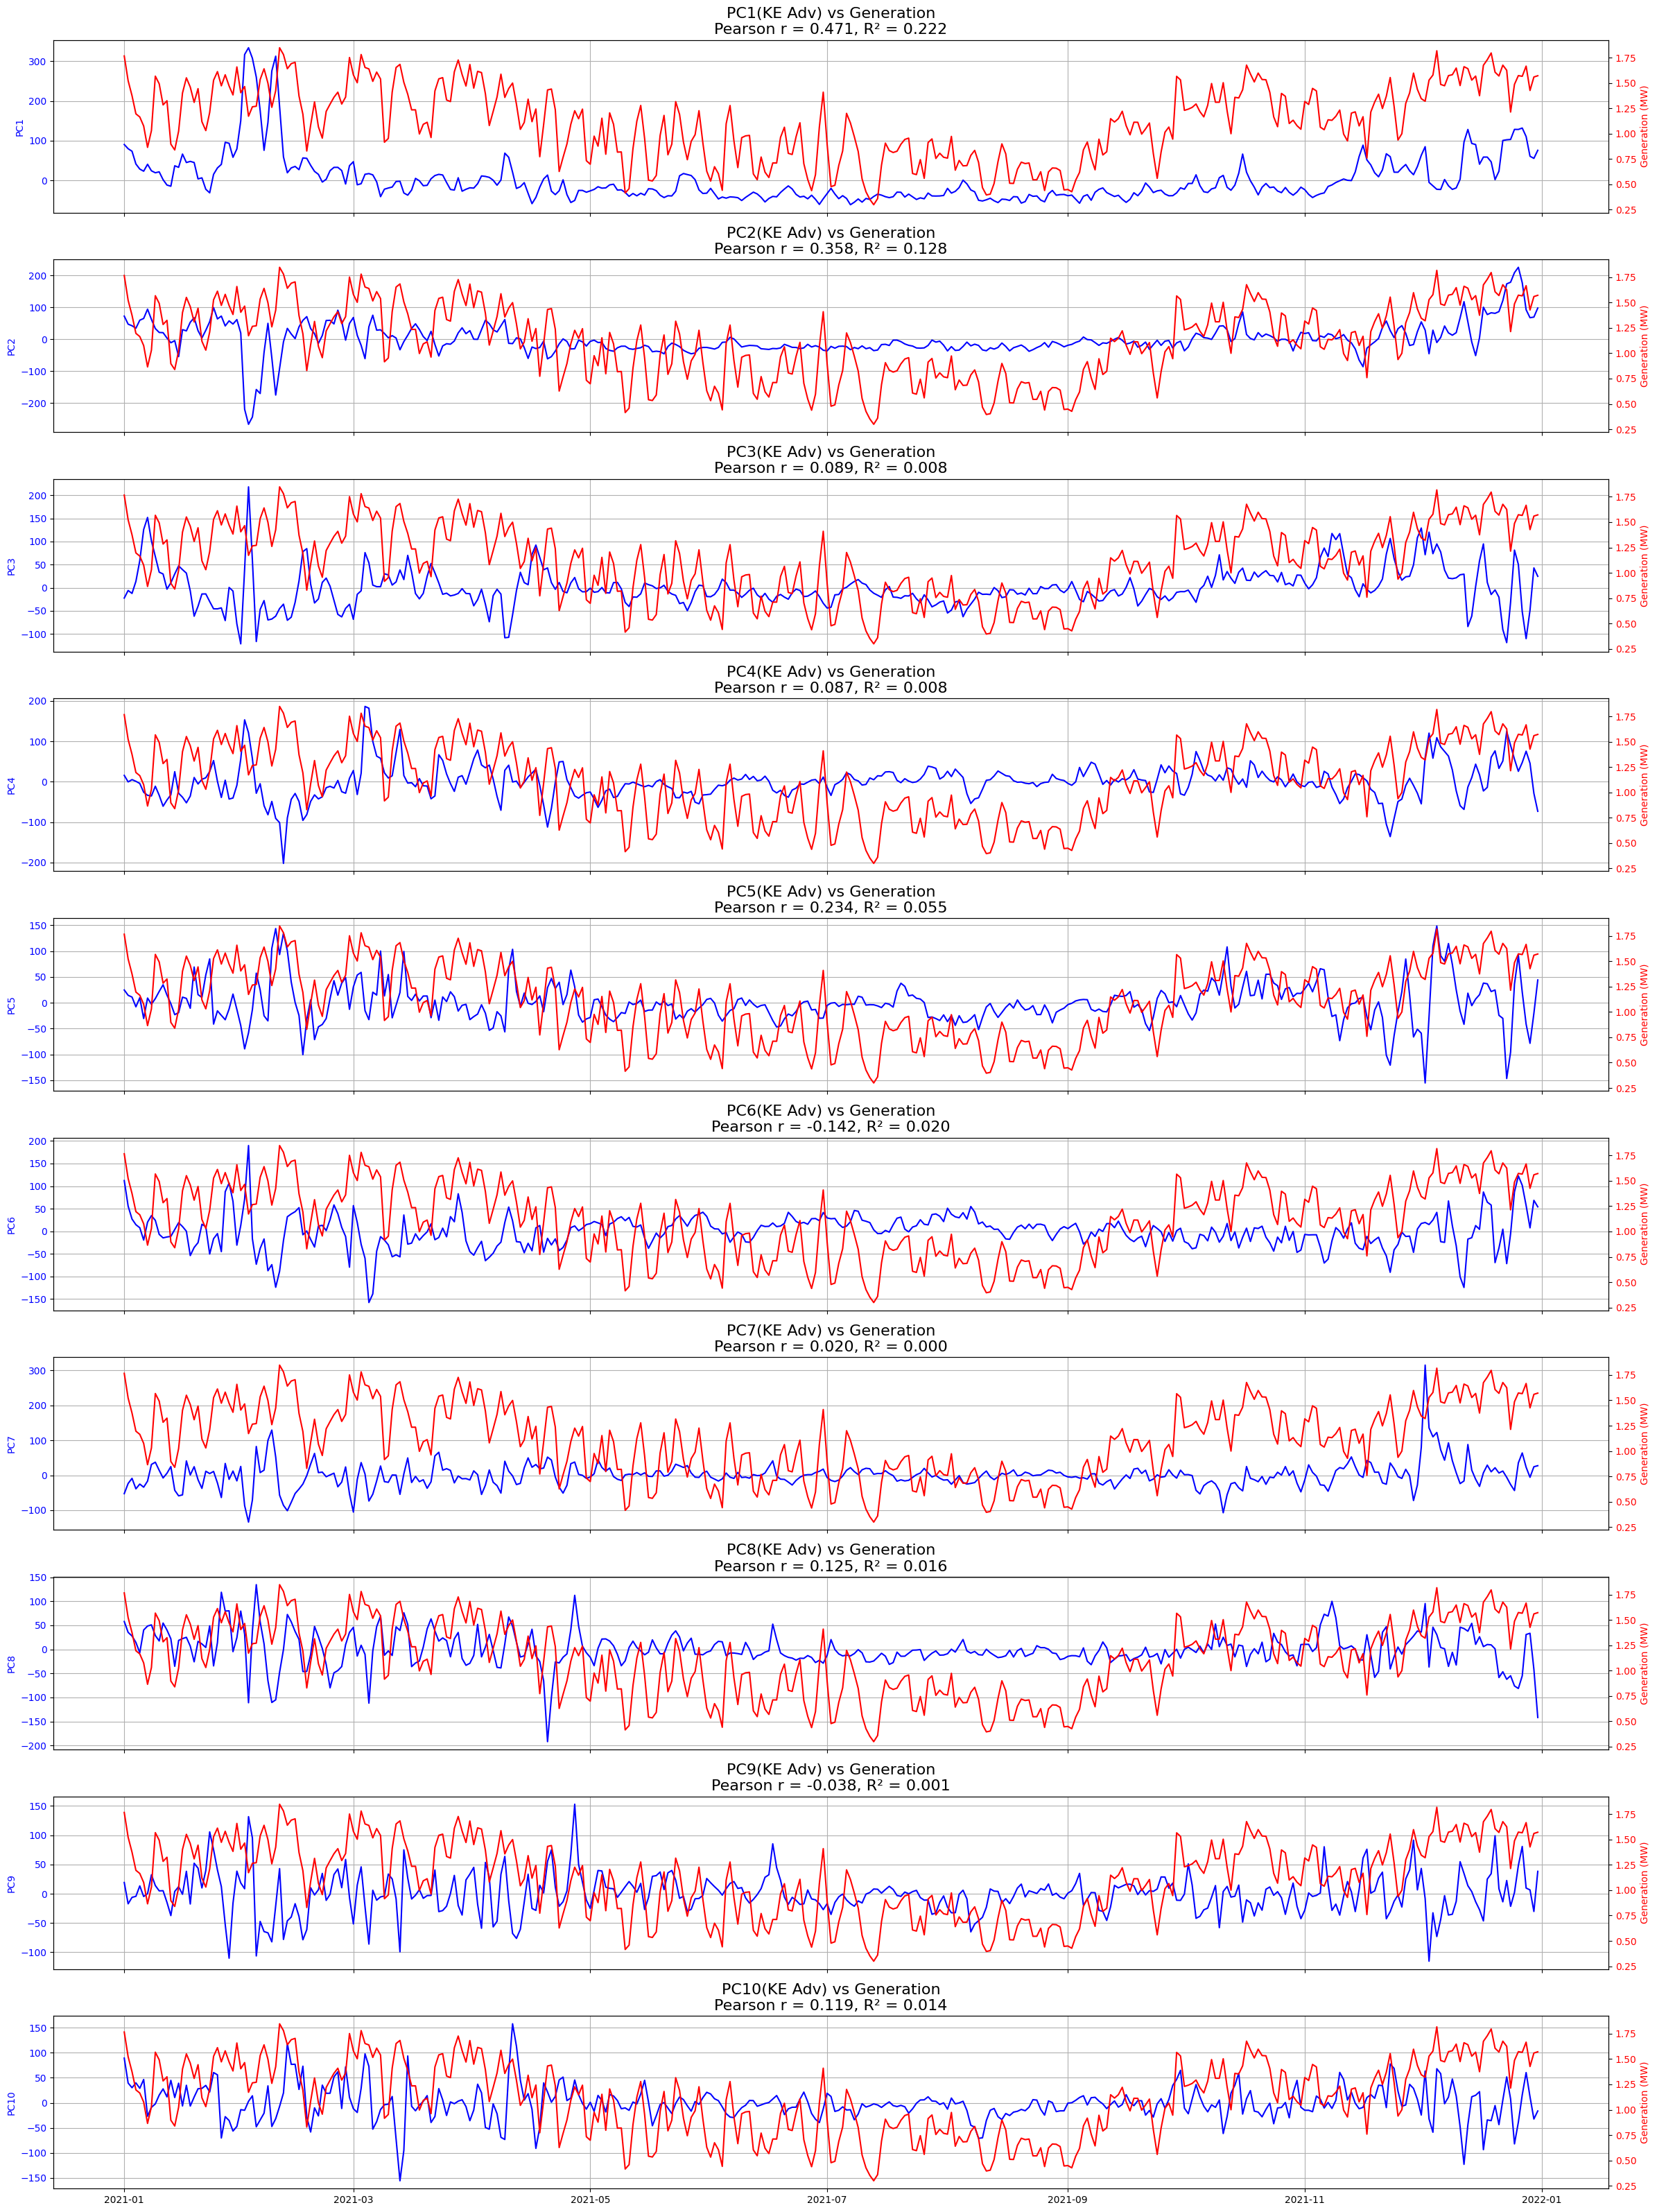

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Convert index to datetime if needed
PC_df.index = pd.to_datetime(PC_df.index)
df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/europe_daily_2021_weighted_avg_gen.parquet')
df['valid_time'] = pd.to_datetime(df['valid_time'])
df.set_index('valid_time', inplace=True)

# Extract generation series
gen_series = df['Weighted Avg Gen (MW per MW installed)']

# Create a single figure with 10 subplots (one for each PC)
fig, axs = plt.subplots(10, 1, figsize=(24, 32), sharex=True)

# Loop over each PC and plot against generation time series with dual y-axes
for i, pc in enumerate(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10']):
    # Invert the sign for PC2
    if pc in ['PC8','PC4','PC7']:
       pc_series = -PC_df[pc]
    else:
      pc_series = PC_df[pc]
    
    # Align the two time series by taking the intersection of the indices
    combined = pd.concat([pc_series, gen_series], axis=1, join='inner')
    combined.columns = [pc, 'Generation']
    
    # Calculate Pearson correlation coefficient and derive R-squared
    corr, _ = pearsonr(combined[pc], combined['Generation'])
    r_squared = corr ** 2
    
    # Plot the PC time series on the left y-axis
    ax1 = axs[i]
    color1 = 'blue'
    ax1.plot(combined.index, combined[pc], label=pc, color=color1)
    ax1.set_ylabel(pc, color=color1)
    ax1.tick_params(axis='y', labelcolor=color1)
    ax1.grid(True)
    
    # Create a second y-axis for Generation values
    ax2 = ax1.twinx()
    color2 = 'red'
    ax2.plot(combined.index, combined['Generation'], label='Generation', color=color2)
    ax2.set_ylabel('Generation (MW)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    
    # Set the title with correlation values
    ax1.set_title(f"{pc}(KE Adv) vs Generation\nPearson r = {corr:.3f}, R² = {r_squared:.3f}", fontsize=16)

# Set a common x-axis label and adjust layout
plt.xlabel('Time')
plt.tight_layout()
plt.show()


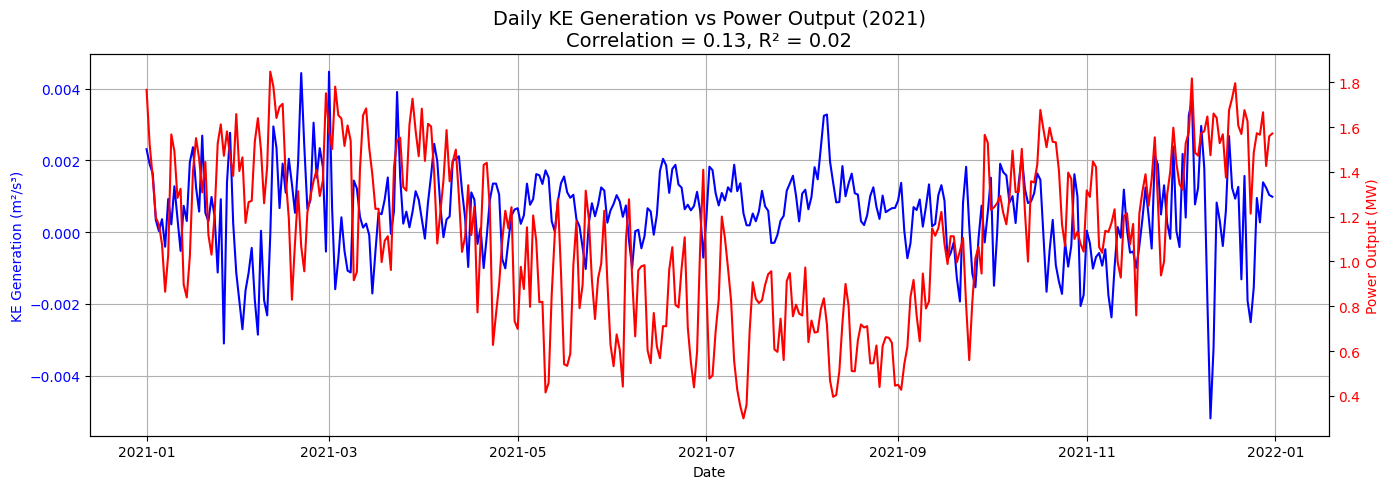

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load power generation data
power_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/europe_daily_2021_weighted_avg_gen.parquet')
power_df['valid_time'] = pd.to_datetime(power_df['valid_time'])
power_df.set_index('valid_time', inplace=True)

# Load KE generation data
ke_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_gen_daily.parquet')
ke_df['valid_time'] = pd.to_datetime(ke_df['valid_time'])

# Filter KE gen for region: lat [-50, 0], lon [145, 205]
ke_filtered = ke_df[
    (ke_df['latitude'] >= 20) & 
    (ke_df['latitude'] <= 75) & 
    (ke_df['longitude'] >= 110) & 
    (ke_df['longitude'] <= 220)
]

# Compute daily regional average KE generation
ke_daily_avg = ke_filtered.groupby('valid_time')['ke_gen'].mean()

# Align with power generation data
combined_df = pd.DataFrame({
    'KE_Gen': ke_daily_avg,
    'Power_Output': power_df['Weighted Avg Gen (MW per MW installed)']
}).dropna()

# Compute correlation and R^2
corr = combined_df.corr().loc['KE_Gen', 'Power_Output']
slope, intercept, r_value, p_value, std_err = linregress(combined_df['KE_Gen'], combined_df['Power_Output'])
r_squared = r_value**2

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 5))

color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('KE Generation (m²/s³)', color=color)
ax1.plot(combined_df.index, combined_df['KE_Gen'], color=color, label='KE Gen')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Power Output (MW)', color=color)
ax2.plot(combined_df.index, combined_df['Power_Output'], color=color, label='Power Output')
ax2.tick_params(axis='y', labelcolor=color)

# Title and correlation
plt.title(f'Daily KE Generation vs Power Output (2021)\nCorrelation = {-corr:.2f}, R² = {r_squared:.2f}', fontsize=14)
fig.tight_layout()
plt.show()


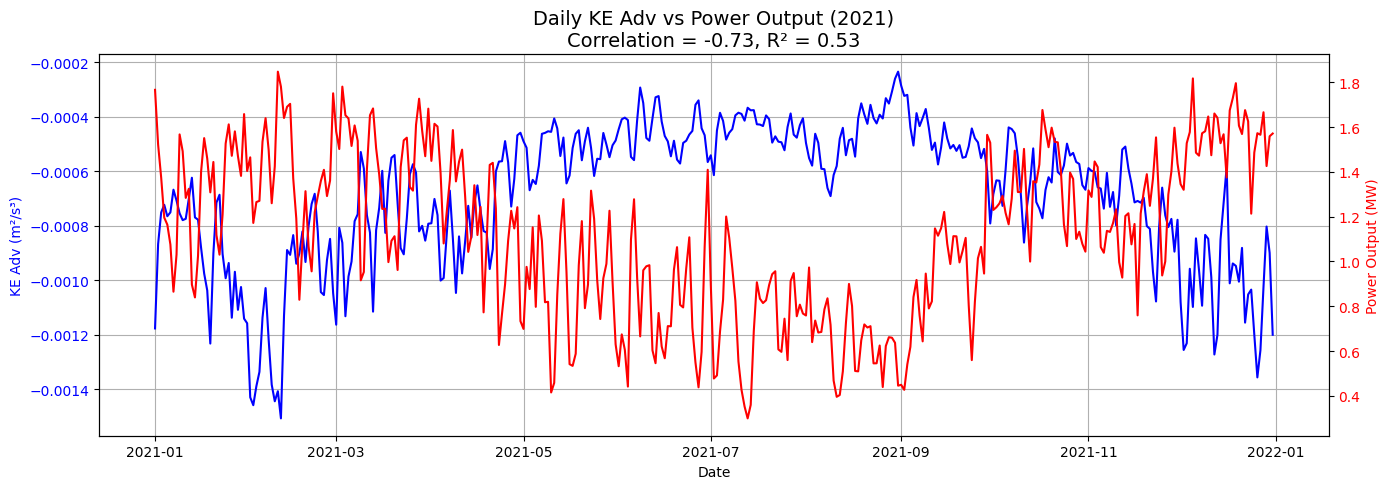

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load power generation data
power_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/europe_daily_2021_weighted_avg_gen.parquet')
power_df['valid_time'] = pd.to_datetime(power_df['valid_time'])
power_df.set_index('valid_time', inplace=True)

# Load KE generation data
ke_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/2021_ke_adv_daily.parquet')
ke_df['valid_time'] = pd.to_datetime(ke_df['valid_time'])

# Filter KE gen for region: lat [-50, 0], lon [145, 205]
ke_filtered = ke_df[
    (ke_df['latitude'] >= 20) & 
    (ke_df['latitude'] <= 75) & 
    (ke_df['longitude'] >= 110) & 
    (ke_df['longitude'] <= 220)
].copy()
ke_filtered['ke_advection'] = -ke_filtered['ke_advection'].abs()
# Compute daily regional average KE generation
ke_daily_avg = ke_filtered.groupby('valid_time')['ke_advection'].mean()

# Align with power generation data
combined_df = pd.DataFrame({
    'KE_Adv': ke_daily_avg,
    'Power_Output': power_df['Weighted Avg Gen (MW per MW installed)']
}).dropna()

# Compute correlation and R^2
corr = combined_df.corr().loc['KE_Adv', 'Power_Output']
slope, intercept, r_value, p_value, std_err = linregress(combined_df['KE_Adv'], combined_df['Power_Output'])
r_squared = r_value**2

# Plotting with dual y-axes
fig, ax1 = plt.subplots(figsize=(14, 5))

color = 'blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('KE Adv (m²/s³)', color=color)
ax1.plot(combined_df.index, combined_df['KE_Adv'], color=color, label='KE Adv')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

ax2 = ax1.twinx()
color = 'red'
ax2.set_ylabel('Power Output (MW)', color=color)
ax2.plot(combined_df.index, combined_df['Power_Output'], color=color, label='Power Output')
ax2.tick_params(axis='y', labelcolor=color)

# Title and correlation
plt.title(f'Daily KE Adv vs Power Output (2021)\nCorrelation = {corr:.2f}, R² = {r_squared:.2f}', fontsize=14)
fig.tight_layout()
plt.show()


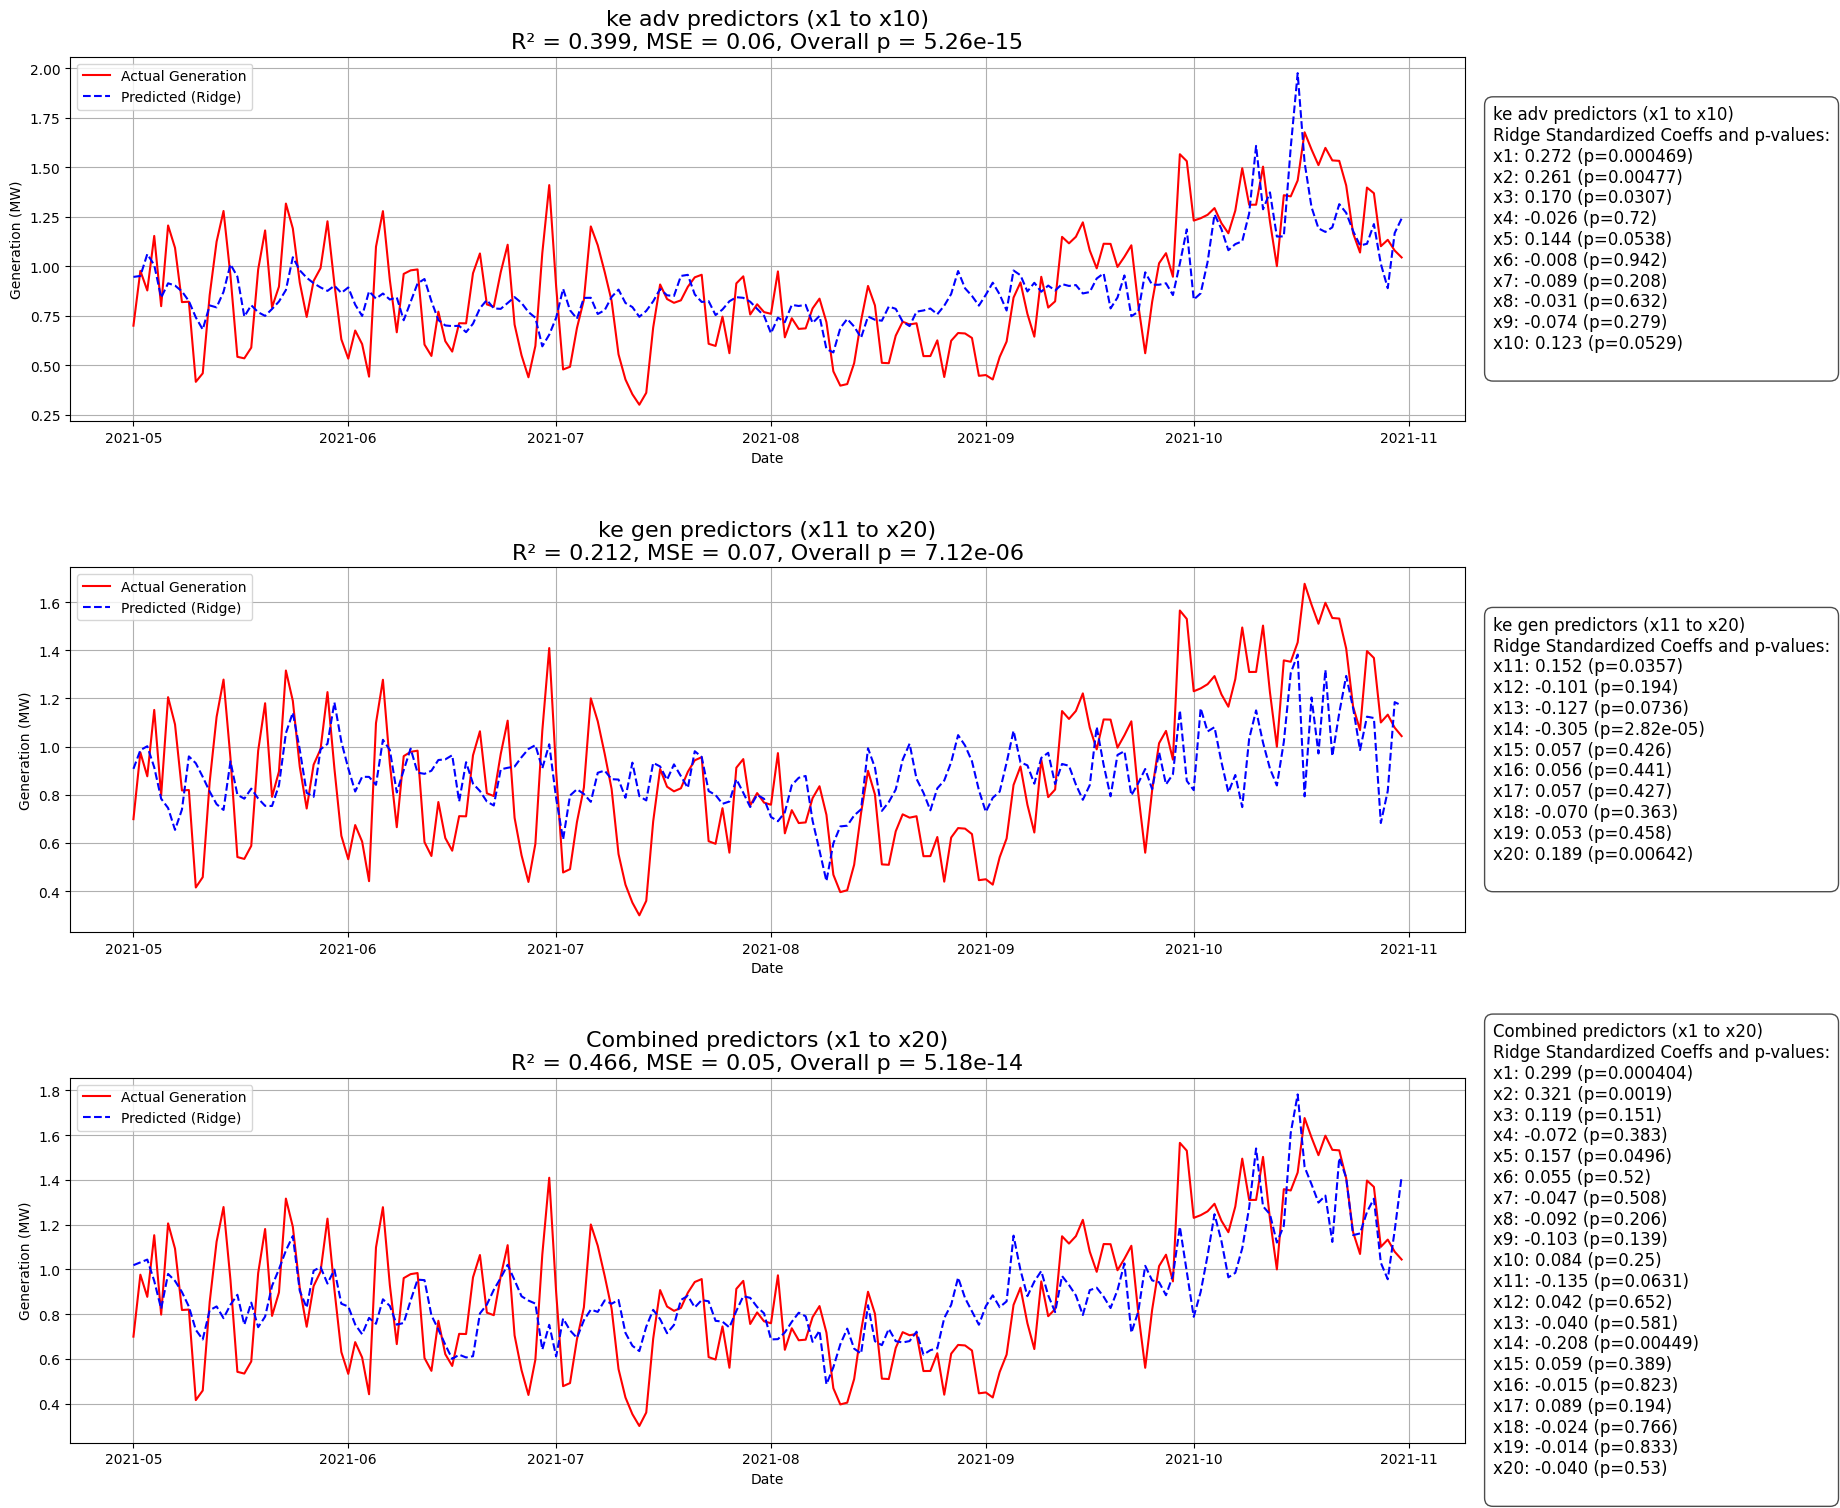

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# -------------------------------
# 1. Load PC time series data (2009)
# -------------------------------
keadv_PC_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/keadv_europe_PC_time_series_2021.parquet')
kegen_PC_df  = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/kegen_europe_PC_time_series_2021.parquet')

keadv_PC_df.index = pd.to_datetime(keadv_PC_df.index)
kegen_PC_df.index = pd.to_datetime(kegen_PC_df.index)

# -------------------------------
# 2. Select top 10 PCs and rename columns
# -------------------------------
# Create column lists for top 10 PCs
keadv_cols = [f'PC{i}' for i in range(1, 11)]
kegen_cols = [f'PC{i}' for i in range(1, 11)]

keadv_top10 = keadv_PC_df[keadv_cols].copy()
kegen_top10 = kegen_PC_df[kegen_cols].copy()

# Rename ke adv PCs to x1 - x10
keadv_top10.columns = [f'x{i}' for i in range(1, 11)]
# Rename ke genn PCs to x11 - x20
kegen_top10.columns = [f'x{i}' for i in range(11, 21)]

# Combine ke adv and ke genn PCs
pc_combined = pd.concat([keadv_top10, kegen_top10], axis=1, join='inner')

# -------------------------------
# 3. Load generation data
# -------------------------------
df_gen = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/europe_daily_2021_weighted_avg_gen.parquet')
df_gen['valid_time'] = pd.to_datetime(df_gen['valid_time'])
df_gen.set_index('valid_time', inplace=True)
gen_series = df_gen['Weighted Avg Gen (MW per MW installed)']

# -------------------------------
# 4. Merge PC data with generation and filter for monsoon season
# -------------------------------
combined = pd.concat([pc_combined, gen_series], axis=1, join='inner')
combined = combined.loc[combined.index.month.isin([5,6,7,8,9,10])]

# Update column names: the first 20 columns are predictors and the generation is the response variable
predictor_names = list(combined.columns[:20])
combined.columns = predictor_names + ['y']

# -------------------------------
# 5. Define Predictor Sets
# -------------------------------
predictor_sets = {
    "ke adv predictors (x1 to x10)": combined[predictor_names[:10]],
    "ke gen predictors (x11 to x20)": combined[predictor_names[10:20]],
    "Combined predictors (x1 to x20)": combined[predictor_names]
}

y = combined['y']

# -------------------------------
# 6. Loop over Predictor Sets and Plot Results
# -------------------------------
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 18))
fig.subplots_adjust(hspace=0.4)

for idx, (title, X) in enumerate(predictor_sets.items()):
    
    # 6.1 Fit Ridge Regression (L2 regularization)
    ridge_model = Ridge(alpha=2.0)
    ridge_model.fit(X, y)
    y_pred = ridge_model.predict(X)
    
    # 6.2 Compute performance metrics
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    # 6.3 Compute p-values using OLS (for interpretation only)
    X_sm = sm.add_constant(X)
    model_sm = sm.OLS(y, X_sm).fit()
    overall_p = model_sm.f_pvalue
    pvals = model_sm.pvalues.drop('const')
    
    # 6.4 Calculate Standardized Coefficients (Beta Weights)
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_std = scaler_X.fit_transform(X)
    y_std = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()
    
    ridge_std = Ridge(alpha=2.0)
    ridge_std.fit(X_std, y_std)
    std_coefs = ridge_std.coef_
    
    # 6.5 Format output text for coefficient box
    textstr = f"{title}\n"
    textstr += "Ridge Standardized Coeffs and p-values:\n"
    for col, coef in zip(X.columns, std_coefs):
        textstr += f"{col}: {coef:.3f} (p={pvals[col]:.3g})\n"
    
    # 6.6 Plot Actual vs. Predicted Generation
    ax = axes[idx]
    ax.plot(y.index, y, label='Actual Generation', color='red')
    ax.plot(y.index, y_pred, label='Predicted (Ridge)', color='blue', linestyle='--')
    ax.set_title(f'{title}\nR² = {r2:.3f}, MSE = {mse:.2f}, Overall p = {overall_p:.3g}', fontsize=16)
    ax.set_xlabel('Date')
    ax.set_ylabel('Generation (MW)')
    ax.legend()
    ax.grid(True)
    
    # 6.7 Add coefficient and p-value text box to the right
    props = dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.7)
    ax.text(1.02, 0.5, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='center', bbox=props)

plt.show()


### Ridge

Optimal lag (days), R² and p-value for each PC mode:
     best_lag        R2       p_value
x1        3.0  0.243766  1.214729e-23
x10      23.0  0.044703  8.135918e-05
x11       5.0  0.249173  4.411193e-24
x12      19.0  0.024870  3.268758e-03
x13      16.0  0.030372  1.078850e-03
x14      25.0  0.158629  2.256115e-14
x15       0.0  0.079864  3.952540e-08
x16       7.0  0.019752  7.741644e-03
x17      22.0  0.018365  1.199565e-02
x18       3.0  0.031314  7.197266e-04
x19      17.0  0.006182  1.432586e-01
x2       17.0  0.136345  1.106764e-12
x20      11.0  0.070326  4.131194e-07
x3       12.0  0.091493  6.658986e-09
x4        3.0  0.016971  1.311558e-02
x5        1.0  0.064900  8.428307e-07
x6       24.0  0.108382  4.618241e-10
x7       30.0  0.028160  2.057491e-03
x8       15.0  0.050394  2.245746e-05
x9       14.0  0.003482  2.702062e-01
Weighted average optimal lag (days) among significant modes: 11.63
Ridge Regression: R² = 0.571, MSE = 0.06


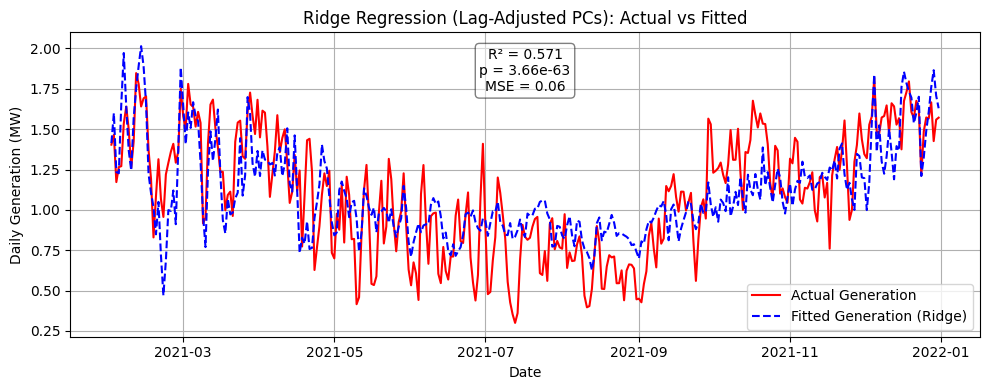

<Figure size 800x600 with 0 Axes>

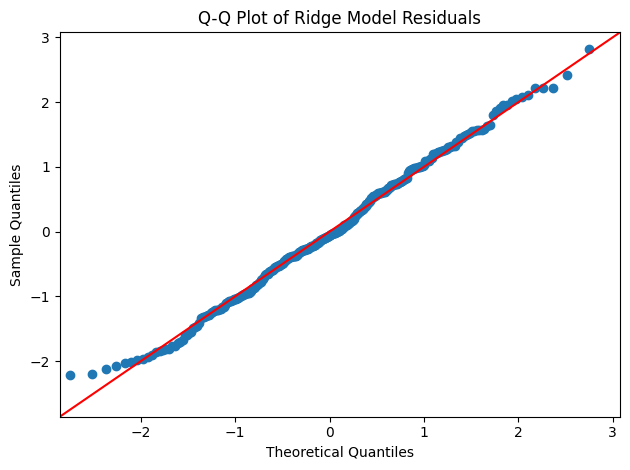

<Figure size 1000x400 with 0 Axes>

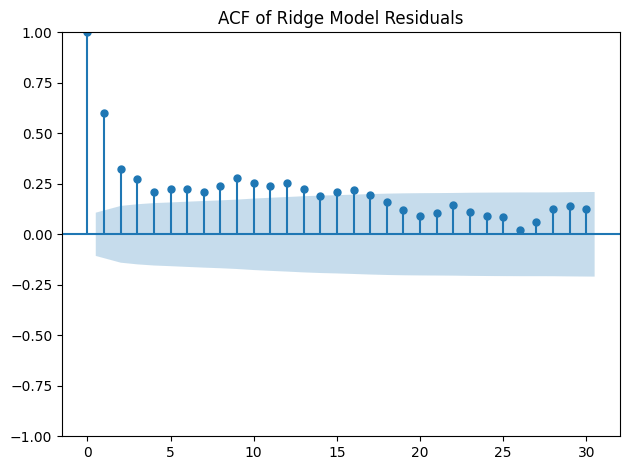

<Figure size 1000x400 with 0 Axes>

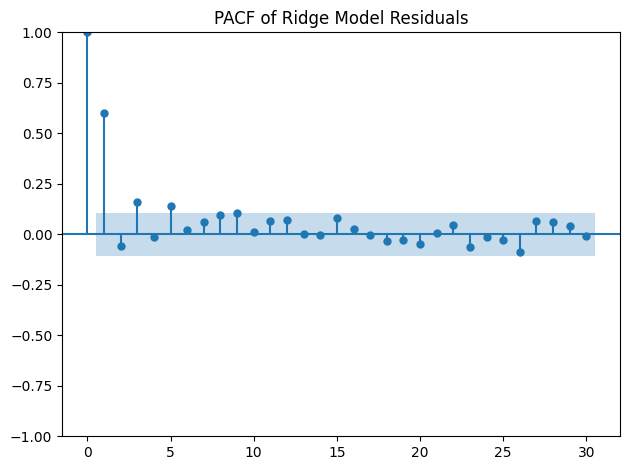

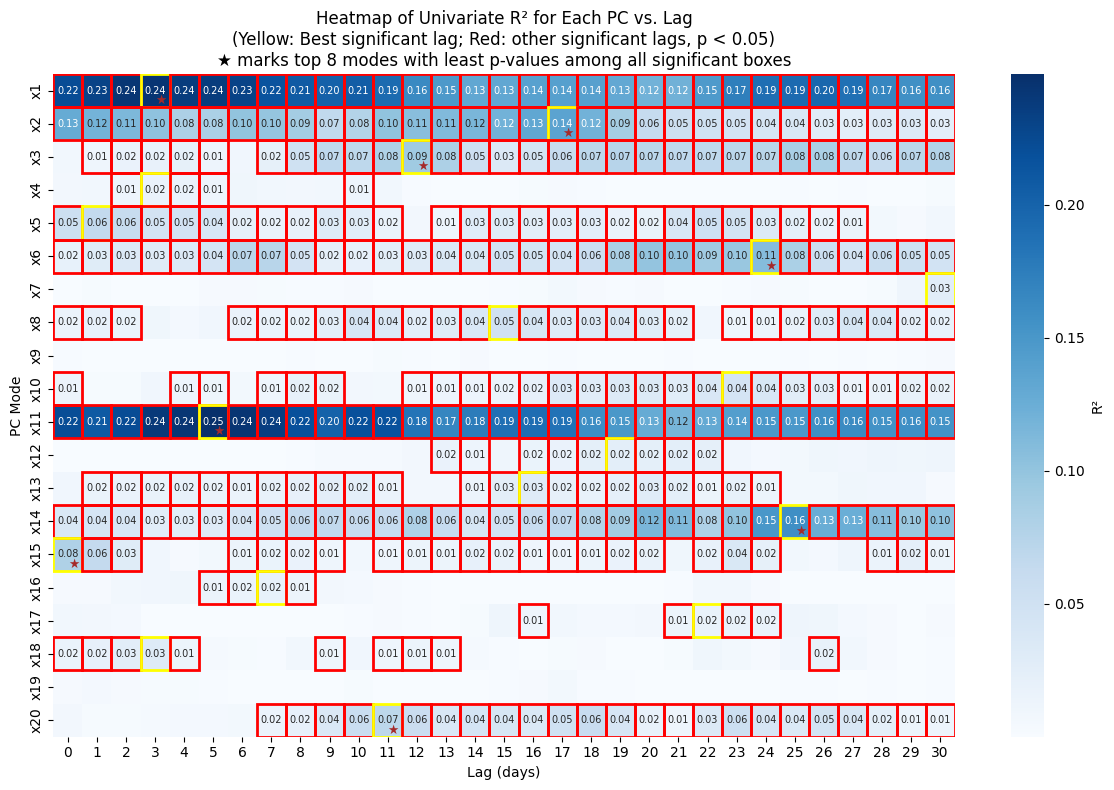


Optimal Lag, R², and p-values for each PC mode:
     best_lag        R2       p_value
x1        3.0  0.243766  1.214729e-23
x10      23.0  0.044703  8.135918e-05
x11       5.0  0.249173  4.411193e-24
x12      19.0  0.024870  3.268758e-03
x13      16.0  0.030372  1.078850e-03
x14      25.0  0.158629  2.256115e-14
x15       0.0  0.079864  3.952540e-08
x16       7.0  0.019752  7.741644e-03
x17      22.0  0.018365  1.199565e-02
x18       3.0  0.031314  7.197266e-04
x19      17.0  0.006182  1.432586e-01
x2       17.0  0.136345  1.106764e-12
x20      11.0  0.070326  4.131194e-07
x3       12.0  0.091493  6.658986e-09
x4        3.0  0.016971  1.311558e-02
x5        1.0  0.064900  8.428307e-07
x6       24.0  0.108382  4.618241e-10
x7       30.0  0.028160  2.057491e-03
x8       15.0  0.050394  2.245746e-05
x9       14.0  0.003482  2.702062e-01


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import pearsonr
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.patches as patches

# =============================================================================
# Stage 1: Determine Optimal Lag for Each PC Mode (with R² and p-value)
# =============================================================================

# -------------------------
# 1. Load Combined PC Time Series and Generation Data
# -------------------------
# Load the top PC time series for KE adv and KE gen (top 10 each)
keadv_PC_df = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/keadv_europe_PC_time_series_2021.parquet')
kegen_PC_df  = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/kegen_europe_PC_time_series_2021.parquet')

# Convert indices to datetime
keadv_PC_df.index = pd.to_datetime(keadv_PC_df.index)
kegen_PC_df.index = pd.to_datetime(kegen_PC_df.index)

# Select top 10 PCs from each and rename columns:
keadv_top10 = keadv_PC_df[[f'PC{i}' for i in range(1, 11)]].copy()
kegen_top10 = kegen_PC_df[[f'PC{i}' for i in range(1, 11)]].copy()
keadv_top10.columns = [f'x{i}' for i in range(1, 11)]
kegen_top10.columns = [f'x{i}' for i in range(11, 21)]

# Combine the two sets (inner join) to obtain 20 predictors.
pc_combined = pd.concat([keadv_top10, kegen_top10], axis=1, join='inner')

# -------------------------
# 2. Load Generation Data
# -------------------------
df_gen = pd.read_parquet('/vol/sandeep_storage/Files2/wind_data/europe/europe_daily_2021_weighted_avg_gen.parquet')
df_gen['valid_time'] = pd.to_datetime(df_gen['valid_time'])
df_gen.set_index('valid_time', inplace=True)
gen_series = df_gen['Weighted Avg Gen (MW per MW installed)']

# Align the PC data and generation data by an inner join.
combined_for_opt = pd.concat([pc_combined, gen_series], axis=1, join='inner')
combined_for_opt.columns = list(pc_combined.columns) + ['y']

# -------------------------
# 3. Determine Optimal Lag for Each PC Mode (0 to 30 days)
# -------------------------
max_lag = 30  # examine lags 0 to 30 days
optimal_info = {}  # dictionary to store best lag, R², and p-value for each PC

# Build full matrices of R² and p-values for later visualization
r2_matrix = pd.DataFrame(index=pc_combined.columns, columns=range(max_lag+1))
pval_matrix = pd.DataFrame(index=pc_combined.columns, columns=range(max_lag+1))

for pc in pc_combined.columns:
    # Initialize variables for significant candidates
    best_r2 = -np.inf
    best_lag = None
    best_p = None
    # Fallback candidate: highest R² overall
    fallback_r2 = -np.inf
    fallback_lag = 0
    fallback_p = np.nan
    
    for lag in range(0, max_lag + 1):
        lagged_series = pc_combined[pc].shift(lag)
        df_temp = pd.concat([lagged_series, gen_series], axis=1).dropna()
        df_temp.columns = ['X', 'y']
        if len(df_temp) > 0:
            model = sm.OLS(df_temp['y'], sm.add_constant(df_temp['X'])).fit()
            current_r2 = model.rsquared
            current_p = model.pvalues.get('X', np.nan)
            r2_matrix.loc[pc, lag] = current_r2
            pval_matrix.loc[pc, lag] = current_p
            
            # Update fallback candidate regardless of p-value
            if current_r2 > fallback_r2:
                fallback_r2 = current_r2
                fallback_lag = lag
                fallback_p = current_p
                
            # Update best candidate only if p-value < 0.05
            if current_p < 0.05 and current_r2 > best_r2:
                best_r2 = current_r2
                best_lag = lag
                best_p = current_p
                
    # If no candidate with p < 0.05 was found, fall back to highest R² overall.
    if best_lag is None:
        best_lag = fallback_lag
        best_r2 = fallback_r2
        best_p = fallback_p
        
    optimal_info[pc] = {'best_lag': best_lag, 'R2': best_r2, 'p_value': best_p}

optimal_df = pd.DataFrame(optimal_info).T.sort_index()
print("Optimal lag (days), R² and p-value for each PC mode:")
print(optimal_df)

# Compute weighted average optimal lag among statistically significant modes (p < 0.05) using R² as weights.
signif_modes = optimal_df[optimal_df['p_value'] < 0.05]
if not signif_modes.empty:
    weighted_avg_lag = (signif_modes['best_lag'] * signif_modes['R2']).sum() / signif_modes['R2'].sum()
    print(f"Weighted average optimal lag (days) among significant modes: {weighted_avg_lag:.2f}")
else:
    print("No significant modes (p < 0.05) found.")

# =============================================================================
# Stage 2: Build a Lag-Adjusted Predictor Using Individual Optimal Lags and Model with Ridge Regression
# =============================================================================

# -------------------------
# 4. Create a New Predictor DataFrame Using Optimal Lags for Each PC
# -------------------------
pc_optimal = pd.DataFrame(index=pc_combined.index)
for pc in pc_combined.columns:
    opt_lag = optimal_info[pc]['best_lag']
    pc_optimal[pc] = pc_combined[pc].shift(opt_lag)

# Option 1: Form a weighted composite using univariate R² as weights (optional).
weights = np.array([optimal_info[pc]['R2'] for pc in pc_combined.columns])
normalized_weights = weights / weights.sum()
composite_PC_optimal = pc_optimal.dot(normalized_weights)
composite_PC_optimal.name = 'Composite_PC_optimal'

# Option 2: For the multivariate model, we keep the full set of lag-adjusted PCs.
X_opt = pc_optimal.copy()

# Ensure alignment with generation series.
data_opt = pd.concat([X_opt, gen_series], axis=1, join='inner').dropna()
data_opt.columns = list(pc_optimal.columns) + ['y']

# -------------------------
# 5. Build a Multivariate Model using Ridge Regression
# -------------------------
X_mult = data_opt[pc_combined.columns]
y_mult = data_opt['y']

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_std = scaler_X.fit_transform(X_mult)
y_std = scaler_y.fit_transform(y_mult.values.reshape(-1, 1)).flatten()

ridge = Ridge(alpha=2.0)
ridge.fit(X_std, y_std)
y_pred_std = ridge.predict(X_std)
y_pred = scaler_y.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()

r2_ridge = r2_score(y_mult, y_pred)
mse_ridge = mean_squared_error(y_mult, y_pred)
print(f"Ridge Regression: R² = {r2_ridge:.3f}, MSE = {mse_ridge:.2f}")

# -------------------------
# 6. Visualize Ridge Results: Actual vs. Fitted
# -------------------------
plt.figure(figsize=(10, 4))
plt.plot(data_opt.index, y_mult, label="Actual Generation", color='red')
plt.plot(data_opt.index, y_pred, label="Fitted Generation (Ridge)", linestyle="--", color='blue')
plt.xlabel("Date")
plt.ylabel("Daily Generation (MW)")
plt.title("Ridge Regression (Lag-Adjusted PCs): Actual vs Fitted")

# Calculate Pearson correlation statistics
r_model, p_model = pearsonr(y_mult, y_pred)
plt.text(0.5, 0.95,
         f"R² = {(r_model**2):.3f}\np = {p_model:.3g}\nMSE = {mse_ridge:.2f}",
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         horizontalalignment='center',
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# Stage 3: Residual Diagnostics
# =============================================================================
# Q-Q Plot of Residuals
residuals = y_mult - y_pred
plt.figure(figsize=(8, 6))
qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Ridge Model Residuals")
plt.tight_layout()
plt.show()

# ACF Plot of Residuals
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=30)
plt.title("ACF of Ridge Model Residuals")
plt.tight_layout()
plt.show()

# PACF Plot of Residuals
plt.figure(figsize=(10, 4))
plot_pacf(residuals, lags=30)
plt.title("PACF of Ridge Model Residuals")
plt.tight_layout()
plt.show()

# =============================================================================
# Stage 4: Heatmap for Univariate Lag Effects (R² only, with best significant lag boxed in yellow, others in red)
#             and with a star on the cell for the top 6 modes having the least p-values among all significant boxes.
# =============================================================================
# Ensure matrix values are float
r2_matrix = r2_matrix.astype(float)
pval_matrix = pval_matrix.astype(float)

# Create custom annotation: show R² value if the corresponding p-value is < 0.05; otherwise, leave blank.
annot = pd.DataFrame("", index=r2_matrix.index, columns=r2_matrix.columns)
for i in range(r2_matrix.shape[0]):
    for j in range(r2_matrix.shape[1]):
        try:
            p_val = float(pval_matrix.iloc[i, j])
        except:
            p_val = np.nan
        if not np.isnan(p_val) and p_val < 0.05:
            annot.iloc[i, j] = f"{r2_matrix.iloc[i, j]:.2f}"
        else:
            annot.iloc[i, j] = ""

plt.figure(figsize=(12, 8))
ax = sns.heatmap(r2_matrix, annot=annot, fmt="", cmap="Blues", cbar_kws={'label': 'R²'}, annot_kws={"fontsize":7})

# First, determine for each mode the minimum p-value among all significant cells (p < 0.05)
min_p_dict = {}
for pc in pval_matrix.index:
    min_val = np.inf
    best_lag_for_star = None
    for lag in pval_matrix.columns:
        try:
            p_val = float(pval_matrix.loc[pc, lag])
        except:
            p_val = np.nan
        if not np.isnan(p_val) and p_val < 0.05 and p_val < min_val:
            min_val = p_val
            best_lag_for_star = lag
    if best_lag_for_star is not None:
        min_p_dict[pc] = (min_val, best_lag_for_star)

# Rank the modes by their minimum p-values (ascending: least p-values first)
sorted_modes = sorted(min_p_dict.items(), key=lambda x: x[1][0])
# Select the top 6 modes (if available)
top_6_modes = [item[0] for item in sorted_modes[:8]]

# Draw boxes over cells where p < 0.05.
# For each PC (row), determine the optimal (best) lag from optimal_info, and then add star on the cell 
# corresponding to the minimum p-value for that mode if the mode is among the top 6.
for i in range(r2_matrix.shape[0]):
    pc = r2_matrix.index[i]
    best_lag_for_pc = optimal_info[pc]['best_lag']
    for j in range(r2_matrix.shape[1]):
        try:
            p_val = float(pval_matrix.iloc[i, j])
        except:
            p_val = np.nan
        if not np.isnan(p_val) and p_val < 0.05:
            # If the current cell is the best candidate (based on optimal_info) then use yellow; otherwise red.
            edge_color = 'yellow' if j == best_lag_for_pc else 'red'
            ax.add_patch(patches.Rectangle((j, i), 1, 1, fill=False, edgecolor=edge_color, lw=2))
            # If this cell corresponds to the mode's minimum p-value AND the mode is in the top 6, add a star.
            if pc in top_6_modes and j == min_p_dict[pc][1]:
                ax.text(j+0.5, i+0.6, "★", horizontalalignment='left',
                        verticalalignment='top', color='brown', fontsize=9)

plt.xlabel("Lag (days)")
plt.ylabel("PC Mode")
plt.title("Heatmap of Univariate R² for Each PC vs. Lag\n(Yellow: Best significant lag; Red: other significant lags, p < 0.05)\n★ marks top 8 modes with least p-values among all significant boxes")
plt.tight_layout()
plt.show()

# =============================================================================
# Stage 4.5: Print Full Table of Optimal Lag, R², and p-value for each PC mode
# =============================================================================
print("\nOptimal Lag, R², and p-values for each PC mode:")
print(optimal_df)


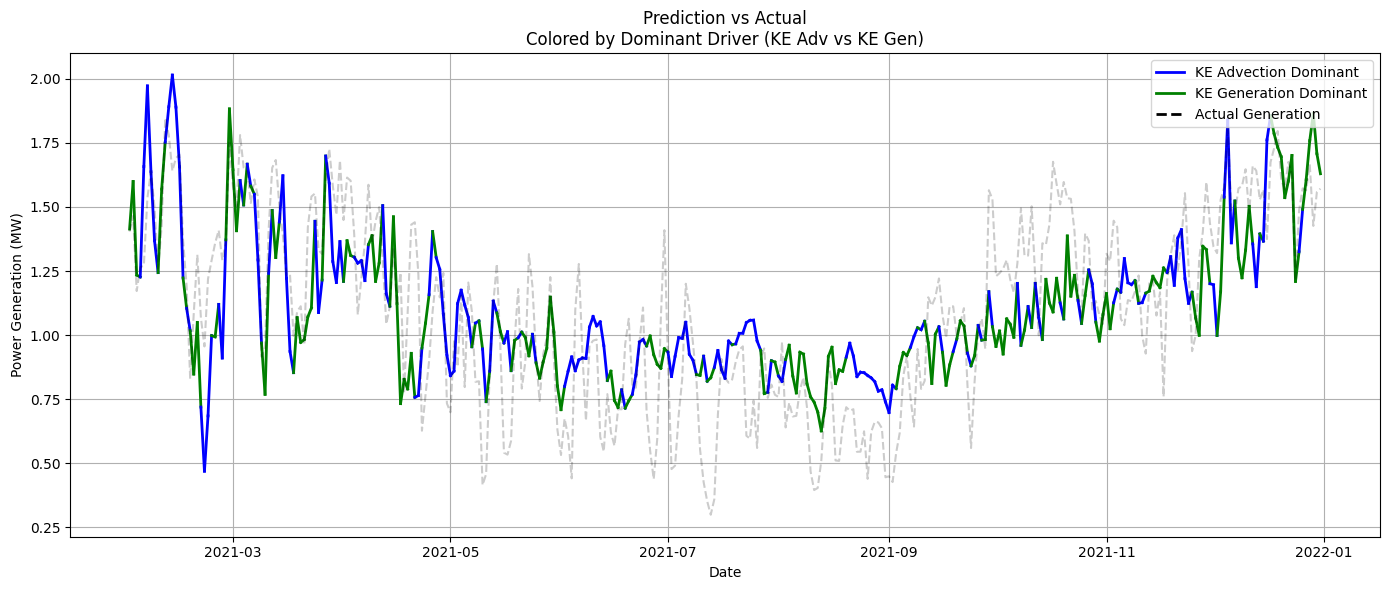

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

# === Step 1: Create lag-adjusted PC dataset using optimal_info ===
pc_optimal = pd.DataFrame(index=pc_combined.index)
for pc in pc_combined.columns:
    lag = optimal_info[pc]['best_lag']
    pc_optimal[pc] = pc_combined[pc].shift(lag)

# === Step 2: Combine with generation data ===
data_opt = pd.concat([pc_optimal, gen_series], axis=1, join='inner').dropna()
X_mult = data_opt.drop(columns=['Weighted Avg Gen (MW per MW installed)'])
y_mult = data_opt['Weighted Avg Gen (MW per MW installed)']

# === Step 3: Fit Ridge Regression ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_std = scaler_X.fit_transform(X_mult)
y_std = scaler_y.fit_transform(y_mult.values.reshape(-1, 1)).flatten()

ridge = Ridge(alpha=2.0)
ridge.fit(X_std, y_std)
y_pred_std = ridge.predict(X_std)
y_pred = scaler_y.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()

# === Step 4: Compute contribution of each PC at each time step ===
X_df = pd.DataFrame(X_std, columns=X_mult.columns, index=data_opt.index)
contributions = X_df.mul(ridge.coef_, axis=1)

# === Step 5: Identify dominant PC and its group (adv/gen) at each time step ===
dominant_pc = contributions.abs().idxmax(axis=1)

# Define KE adv and KE gen PC names (you used x1–x30 for adv, x31–x60 for gen)
ke_adv_pcs = set([f'x{i}' for i in range(1, 11)])
ke_gen_pcs = set([f'x{i}' for i in range(11, 21)])

# Assign color based on group
group_color = {'adv': 'blue', 'gen': 'green'}
dominant_group = dominant_pc.map(lambda pc: 'adv' if pc in ke_adv_pcs else 'gen')

# === Step 6: Plot prediction colored by KE adv vs KE gen ===
plt.figure(figsize=(14, 6))
for t in range(len(y_pred) - 1):
    grp = dominant_group.iloc[t]
    plt.plot(data_opt.index[t:t+2], y_pred[t:t+2], color=group_color[grp], linewidth=2)
    verticalalignment='top',
    horizontalalignment='center'
# Overlay actual generation
plt.plot(data_opt.index, y_mult, label='Actual Generation', color='black', linestyle='--',alpha=0.2)

# === Step 7: Legend & Labels ===
legend_lines = [
    Line2D([0], [0], color='blue', lw=2, label='KE Advection Dominant'),
    Line2D([0], [0], color='green', lw=2, label='KE Generation Dominant'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', label='Actual Generation')
]

plt.legend(handles=legend_lines, loc='upper right')
plt.xlabel("Date")
plt.ylabel("Power Generation (MW)")
plt.title("Prediction vs Actual\nColored by Dominant Driver (KE Adv vs KE Gen)")
plt.grid(True)
plt.tight_layout()
plt.show()


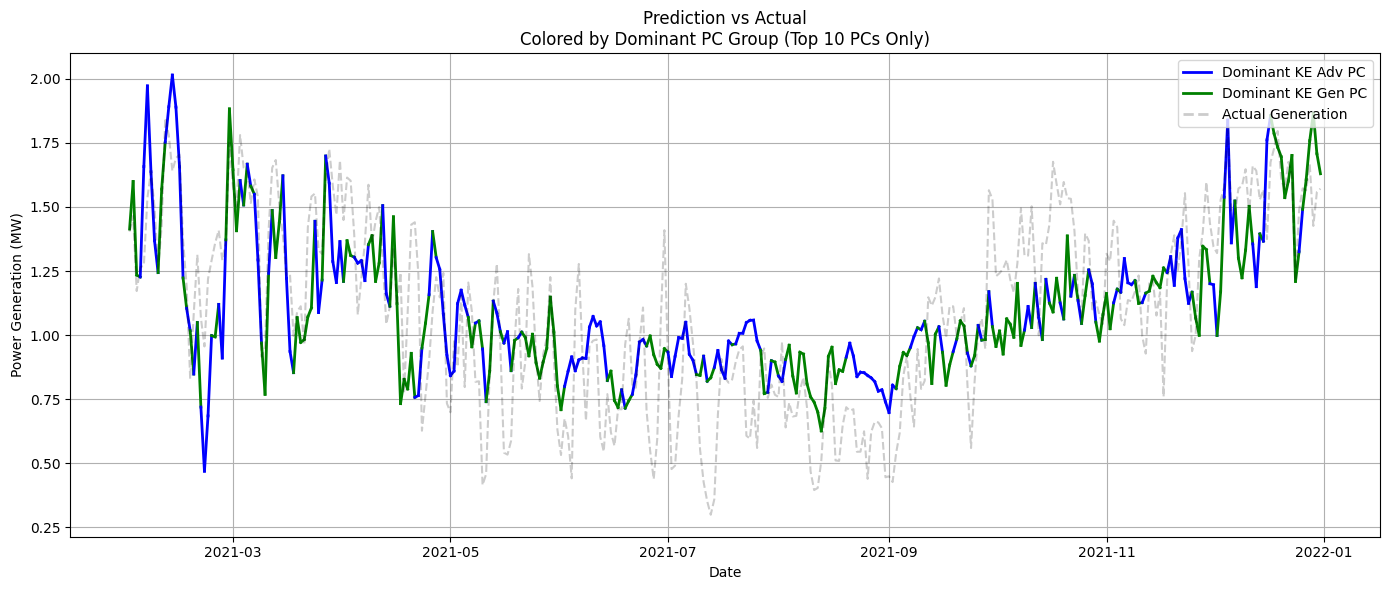

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D

# === Step 1: Create lag-adjusted PC dataset using optimal_info ===
pc_optimal = pd.DataFrame(index=pc_combined.index)
for pc in pc_combined.columns:
    lag = optimal_info[pc]['best_lag']
    pc_optimal[pc] = pc_combined[pc].shift(lag)

# === Step 2: Combine with generation data ===
data_opt = pd.concat([pc_optimal, gen_series], axis=1, join='inner').dropna()
X_mult = data_opt.drop(columns=['Weighted Avg Gen (MW per MW installed)'])
y_mult = data_opt['Weighted Avg Gen (MW per MW installed)']

# === Step 3: Fit Ridge Regression ===
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_std = scaler_X.fit_transform(X_mult)
y_std = scaler_y.fit_transform(y_mult.values.reshape(-1, 1)).flatten()

ridge = Ridge(alpha=2.0)
ridge.fit(X_std, y_std)
y_pred_std = ridge.predict(X_std)
y_pred = scaler_y.inverse_transform(y_pred_std.reshape(-1, 1)).flatten()

# === Step 4: Compute contributions of each PC ===
X_df = pd.DataFrame(X_std, columns=X_mult.columns, index=data_opt.index)
contributions = X_df.mul(ridge.coef_, axis=1)

# === Step 5: Identify top 10 overall contributing PCs ===
top_10_pcs = contributions.abs().sum().sort_values(ascending=False).head(10).index.tolist()

# === Step 6: Tag each top PC as KE adv or KE gen ===
ke_adv_pcs = set([f'x{i}' for i in range(1, 11)])
ke_gen_pcs = set([f'x{i}' for i in range(11, 21)])
pc_group_map = {pc: 'adv' if pc in ke_adv_pcs else 'gen' for pc in top_10_pcs}

# === Step 7: For each timestep, find dominant PC (among top 10 only) and its group ===
dominant_pc = contributions[top_10_pcs].abs().idxmax(axis=1)
dominant_group = dominant_pc.map(pc_group_map)

# === Step 8: Define color mapping for the two groups ===
group_color = {'adv': 'blue', 'gen': 'green'}

# === Step 9: Plot the prediction, color-coded by dominant PC group ===
plt.figure(figsize=(14, 6))
for t in range(len(y_pred) - 1):
    group = dominant_group.iloc[t]
    color = group_color[group]
    plt.plot(data_opt.index[t:t+2], y_pred[t:t+2], color=color, linewidth=2)

# === Step 10: Overlay faded actual generation ===
plt.plot(data_opt.index, y_mult, label='Actual Generation', color='black', linestyle='--', alpha=0.2)

# === Step 11: Add legend and labels ===
legend_lines = [
    Line2D([0], [0], color='blue', lw=2, label='Dominant KE Adv PC'),
    Line2D([0], [0], color='green', lw=2, label='Dominant KE Gen PC'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', alpha=0.2, label='Actual Generation')
]

plt.legend(handles=legend_lines, loc='upper right')
plt.xlabel("Date")
plt.ylabel("Power Generation (MW)")
plt.title("Prediction vs Actual\nColored by Dominant PC Group (Top 10 PCs Only)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [28]:
# =============================================================================
# Stage 5: Print Top 8 Most Significant Modes (Lowest p-values among all)
# =============================================================================

# Prepare the top 8 modes from earlier sorted_modes (already contains lowest p-values)
top8_summary = []

print("\n🔍 Top 10 Most Statistically Significant PC Modes (based on lowest p-values):\n")
print("{:<6} {:<10} {:<8} {:<10}".format("Mode", "Best Lag", "R²", "p-value"))
print("-" * 40)
for mode, (pval, lag) in sorted_modes[:10]:
    r2_val = r2_matrix.loc[mode, lag]
    print("{:<6} {:<10} {:<8.3f} {:<10.3g}".format(mode, lag, r2_val, pval))
    top8_summary.append((mode, lag, r2_val, pval))

# Optionally: Store in DataFrame for later export or use
top8_df = pd.DataFrame(top8_summary, columns=["Mode", "Best Lag", "R²", "p-value"])



🔍 Top 10 Most Statistically Significant PC Modes (based on lowest p-values):

Mode   Best Lag   R²       p-value   
----------------------------------------
x11    5          0.249    4.41e-24  
x1     3          0.244    1.21e-23  
x14    25         0.159    2.26e-14  
x2     17         0.136    1.11e-12  
x6     24         0.108    4.62e-10  
x3     12         0.091    6.66e-09  
x15    0          0.080    3.95e-08  
x20    11         0.070    4.13e-07  
x5     1          0.065    8.43e-07  
x8     15         0.050    2.25e-05  


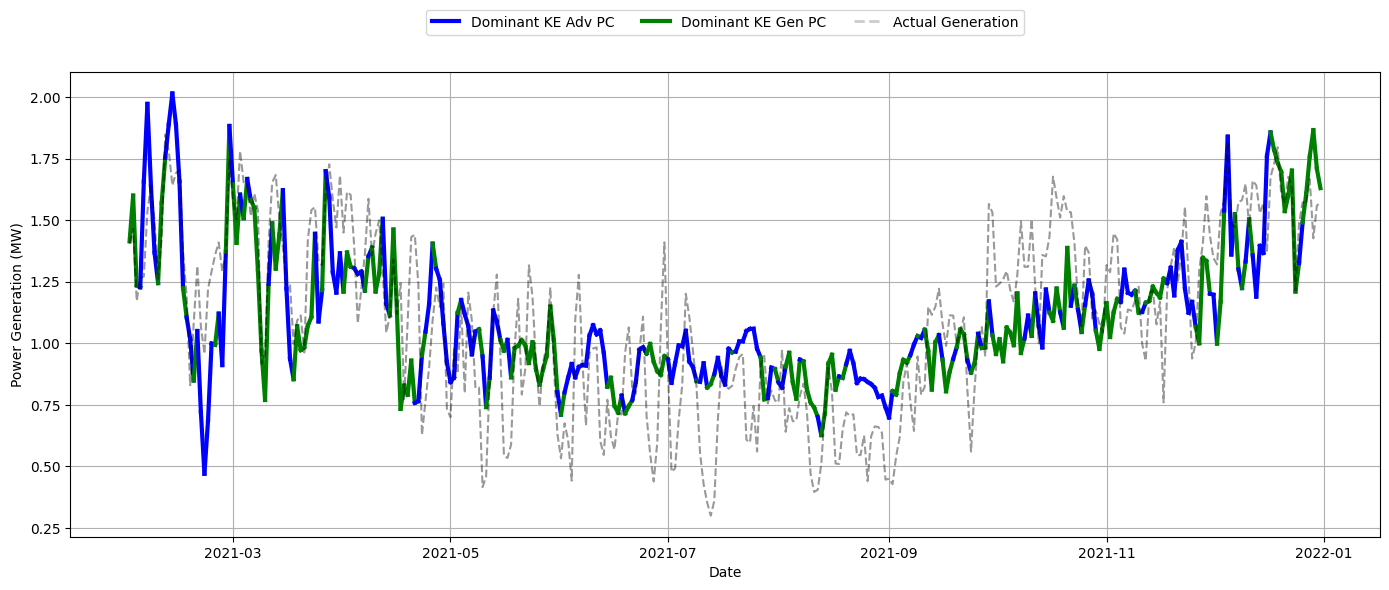

In [3]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Step 1: Define the 10 most significant PCs from your list ===
significant_pcs = ['x11', 'x1', 'x14', 'x2', 'x6', 'x3', 'x15', 'x20', 'x5', 'x8']

# === Step 2: Identify group of each PC (adv or gen) ===
ke_adv_pcs = set([f'x{i}' for i in range(1, 11)])
ke_gen_pcs = set([f'x{i}' for i in range(11, 21)])
pc_group_map = {pc: 'adv' if pc in ke_adv_pcs else 'gen' for pc in significant_pcs}

# === Step 3: Compute dominant PC (among top 10) per timestep ===
dominant_pc = contributions[significant_pcs].abs().idxmax(axis=1)
dominant_group = dominant_pc.map(pc_group_map)

# === Step 4: Color mapping for 2 groups ===
group_color = {'adv': 'blue', 'gen': 'green'}

# === Step 5: Plot prediction colored by dominant group ===
plt.figure(figsize=(14, 6))
for t in range(len(y_pred) - 1):
    group = dominant_group.iloc[t]
    color = group_color[group]
    plt.plot(data_opt.index[t:t+2], y_pred[t:t+2], color=color, linewidth=3)

# === Step 6: Actual generation (faded) ===
plt.plot(data_opt.index, y_mult, label='Actual Generation', color='black', linestyle='--', alpha=0.4)

# === Step 7: Legend ===
legend_lines = [
    Line2D([0], [0], color='blue', lw=3, label='Dominant KE Adv PC'),
    Line2D([0], [0], color='green', lw=3, label='Dominant KE Gen PC'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', alpha=0.2, label='Actual Generation')
]

plt.legend(handles=legend_lines, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.xlabel("Date")
plt.ylabel("Power Generation (MW)")
#plt.title("\nPrediction vs Actual\nColored by Dominant PC (Top 10 Most Statistically Significant)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Visualize PCs  contribution across time

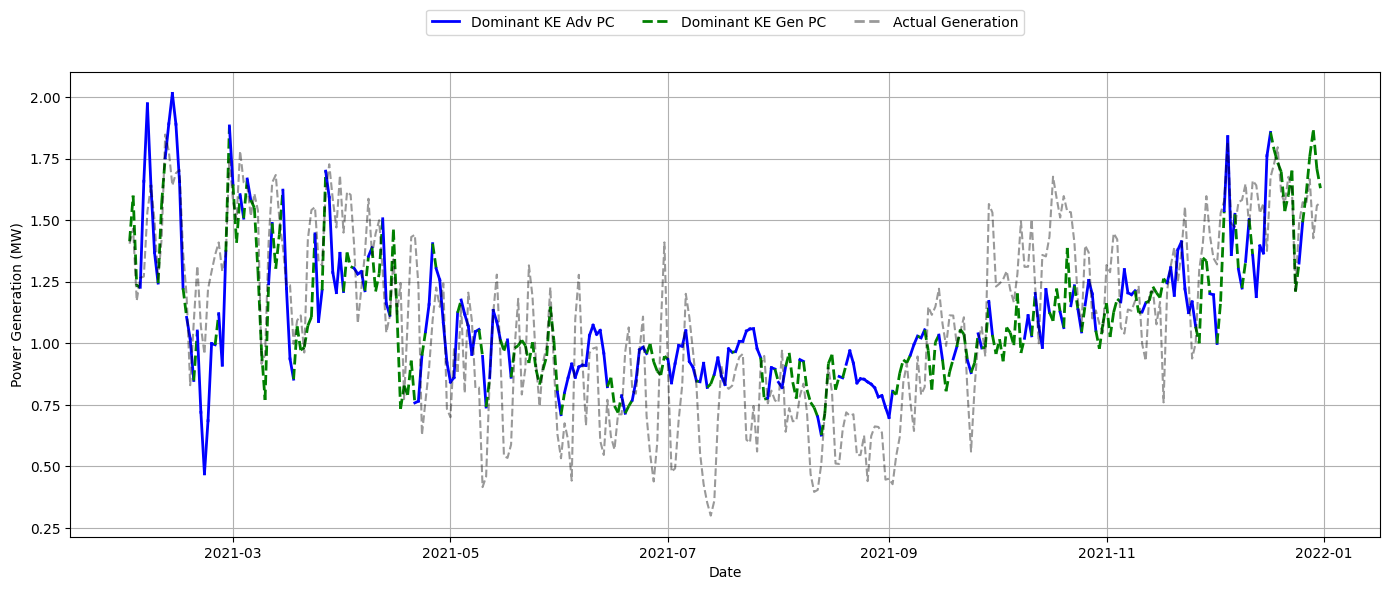

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# === Step 1: Define the 10 most significant PCs from your list ===
significant_pcs = ['x11', 'x1', 'x14', 'x2', 'x6', 'x3', 'x15', 'x20', 'x5', 'x8']

# === Step 2: Identify group of each PC (adv or gen) ===
ke_adv_pcs = set([f'x{i}' for i in range(1, 11)])
ke_gen_pcs = set([f'x{i}' for i in range(11, 21)])
pc_group_map = {pc: 'adv' if pc in ke_adv_pcs else 'gen' for pc in significant_pcs}

# === Step 3: Compute dominant PC (among top 10) per timestep ===
dominant_pc = contributions[significant_pcs].abs().idxmax(axis=1)
dominant_group = dominant_pc.map(pc_group_map)

# === Step 4: Define color and style mapping ===
group_style = {
    'adv': {'color': 'blue', 'linestyle': '-'},
    'gen': {'color': 'green', 'linestyle': '--'}
}

# === Step 5: Plot prediction colored by dominant group ===
plt.figure(figsize=(14, 6))
for t in range(len(y_pred) - 1):
    group = dominant_group.iloc[t]
    style = group_style[group]
    plt.plot(data_opt.index[t:t+2], y_pred[t:t+2], 
             color=style['color'], linestyle=style['linestyle'], linewidth=2)

# === Step 6: Actual generation (faded) ===
plt.plot(data_opt.index, y_mult, label='Actual Generation', color='black', linestyle='--', alpha=0.4)

# === Step 7: Legend ===
legend_lines = [
    Line2D([0], [0], color='blue', lw=2, linestyle='-', label='Dominant KE Adv PC'),
    Line2D([0], [0], color='green', lw=2, linestyle='--', label='Dominant KE Gen PC'),
    Line2D([0], [0], color='black', lw=2, linestyle='--', alpha=0.4, label='Actual Generation')
]

plt.legend(handles=legend_lines, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.xlabel("Date")
plt.ylabel("Power Generation (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()


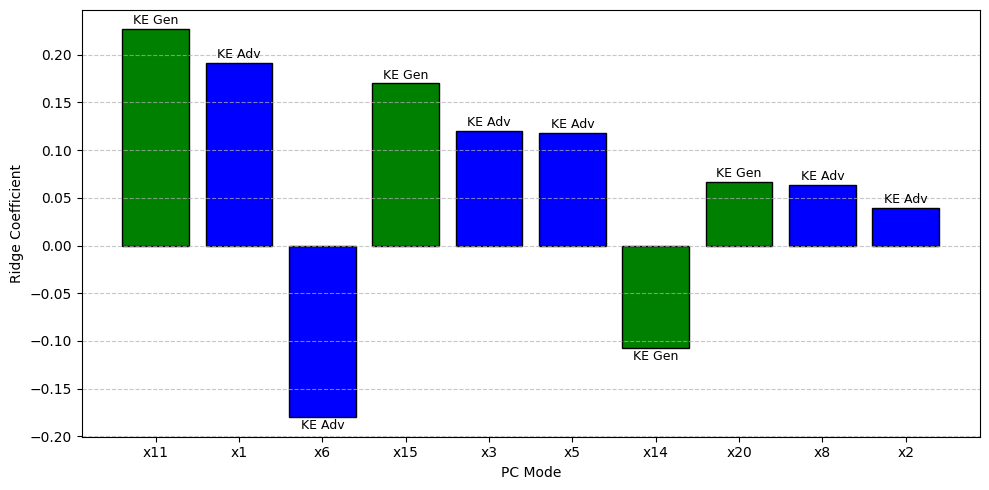

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# === Define top 10 PCs and their groups ===
significant_pcs = ['x11', 'x1', 'x14', 'x2', 'x6', 'x3', 'x15', 'x20', 'x5', 'x8']
ke_adv_pcs = {f'x{i}' for i in range(1, 11)}
pc_group_map = {pc: 'KE Adv' if pc in ke_adv_pcs else 'KE Gen' for pc in significant_pcs}

# === Get Ridge coefficients ===
ridge_coeffs = pd.Series(ridge.coef_, index=X_mult.columns)

# === Build DataFrame for contributions ===
contributions_df = pd.DataFrame({
    'PC': significant_pcs,
    'Coefficient': ridge_coeffs[significant_pcs],
    'Abs_Coefficient': ridge_coeffs[significant_pcs].abs(),
    'Group': [pc_group_map[pc] for pc in significant_pcs]
})

# === Sort by absolute value ===
contributions_df.sort_values(by='Abs_Coefficient', ascending=False, inplace=True)

# === Plot ===
plt.figure(figsize=(10, 5))
colors = contributions_df['Group'].map({'KE Adv': 'blue', 'KE Gen': 'green'})
plt.bar(contributions_df['PC'], contributions_df['Coefficient'], color=colors, edgecolor='black')

# === Annotate group name on top of bars ===
for i, row in contributions_df.iterrows():
    plt.text(row.name, row.Coefficient + 0.002 * np.sign(row.Coefficient),
             row['Group'], ha='center', va='bottom' if row.Coefficient > 0 else 'top',
             fontsize=9, color='black')

# === Formatting ===
plt.ylabel('Ridge Coefficient')
plt.xlabel('PC Mode')
#plt.title('Top 10 Statistically Significant PCs\nSorted by |Coefficient| with Group Labels')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


/tmp/ipykernel_247315/1529965740.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')  # tab10 has 10 distinct visually-friendly colors


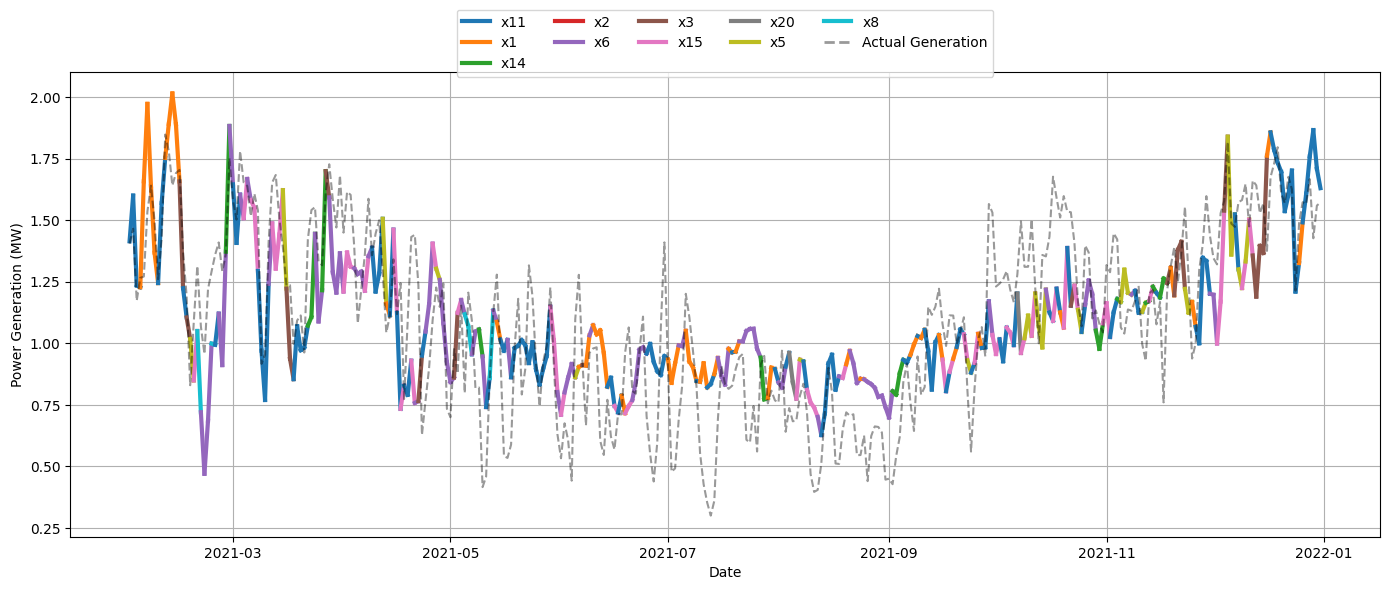

In [15]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.cm import get_cmap

# === Step 1: Define the 10 most significant PCs from your list ===
significant_pcs = ['x11', 'x1', 'x14', 'x2', 'x6', 'x3', 'x15', 'x20', 'x5', 'x8']

# === Step 2: Assign a unique color to each PC using tab10 colormap ===
cmap = get_cmap('tab10')  # tab10 has 10 distinct visually-friendly colors
pc_colors = {pc: cmap(i) for i, pc in enumerate(significant_pcs)}

# === Step 3: Find dominant PC per time step ===
dominant_pc = contributions[significant_pcs].abs().idxmax(axis=1)

# === Step 4: Plot the predicted curve with segment color based on dominant PC ===
plt.figure(figsize=(14, 6))
for t in range(len(y_pred) - 1):
    pc = dominant_pc.iloc[t]
    color = pc_colors[pc]
    plt.plot(data_opt.index[t:t+2], y_pred[t:t+2], color=color, linewidth=3)

# === Step 5: Overlay actual generation curve ===
plt.plot(data_opt.index, y_mult, label='Actual Generation', color='black', linestyle='--', alpha=0.4)

# === Step 6: Build dynamic legend ===
legend_lines = [Line2D([0], [0], color=pc_colors[pc], lw=3, label=pc) for pc in significant_pcs]
legend_lines.append(Line2D([0], [0], color='black', lw=2, linestyle='--', alpha=0.4, label='Actual Generation'))

plt.legend(handles=legend_lines, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
plt.xlabel("Date")
plt.ylabel("Power Generation (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()
